# Разработка моделей машинного обучения для отбора коров с высоким удоем и качественным молоком

**Цель проекта:**
Разработать и обучить две модели машинного обучения для принятия объективных решений о покупке коров на основании их предполагаемой продуктивности и качества молока.

**Задачи исследования:**

1. **Анализ данных:**
    - Исследовать предоставленные данные, выявить закономерности и взаимосвязи между признаками.
    - Провести исследовательский и корреляционный анализ данных для построения качественных моделей.
2. **Моделирование:**
    - Построить регрессионную модель для прогнозирования возможного удоя коровы за год (в килограммах).
    - Разработать классификационную модель для оценки вероятности получения вкусного молока.
3. **Критерии отбора коров:**
    - Удой должен составлять не менее 6000 кг молока в год.
    - Молоко должно соответствовать критериям вкуса фермера.
4. **Оценка качества моделей:**
    - Для регрессионной модели использовать метрики R², MSE, MAE, RMSE.
    - Для классификационной модели оценить precision, recall, accuracy, а также построить матрицу ошибок.
    - Сравнить качество моделей с учётом различных подходов к обработке данных.
5. **Прогнозирование:**
    - Прогнозировать удой и вкус молока для коров из нового стада, доступных для покупки.
6. **Рекомендации фермеру:**
    - Отобрать коров, соответствующих заданным критериям.
    - Сформулировать рекомендации для дальнейшего отбора и управления рисками.

**Итоговые ответы, которые необходимо дать в выводе:**

- Сколько коров из предложенного стада удовлетворяют критериям фермера.
- Какие рекомендации можно дать для дальнейшей оптимизации отбора коров.
- Какой уровень риска остаётся для фермера при покупке выбранных коров.
- Как можно улучшить модели и их применение в будущем.

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import (
    f_oneway,
    ttest_ind,
    chi2_contingency
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve
)
from sklearn.compose import ColumnTransformer
from scipy import stats as st

## Загрузка данных

- Загрузим каждый CSV-файл в отдельный датафрейм, используя библиотеку pandas.
- Выведем первые строки каждого датафрейма для знакомства с данными.
- Получим общую информацию о каждом датафрейме, чтобы понять структуру и типы данных.

### Описание данных:

В основных данных есть информация о пользователях, их поездках и подписках.

1. Файл `ferma_main.csv` содержит данные о стаде фермера на текущий момент. Описание данных:
    - `id` — уникальный идентификатор коровы.
    - `Удой, кг` — масса молока, которую корова даёт в год (в килограммах).
    - `ЭКЕ (Энергетическая кормовая единица)` — показатель питательности корма коровы.
    - `Сырой протеин, г` — содержание сырого протеина в корме (в граммах).
    - `СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме коровы.
    - `Порода` — порода коровы.
    - `Тип пастбища` — ландшафт лугов, на которых паслась корова.
    - `порода папы_быка` — порода папы коровы.
    - `Жирность,%` — содержание жиров в молоке (в процентах).
    - `Белок,%` — содержание белков в молоке (в процентах).
    - `Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (`вкусно`, `не вкусно`).
    - `Возраст` — возраст коровы, бинарный признак (`менее_2_лет`, `более_2_лет`).
    
    Признаки в датасете `ferma_main.csv` можно разделить на группы.
    - Характеристики коровы: `id`, `Порода`, `порода папы_быка`, `Возраст`.
    - Характеристики корма: `ЭКЕ (Энергетическая кормовая единица)`, `Сырой протеин, г`, `СПО (Сахаро-протеиновое соотношение)`.
    - Характеристика пастбища: `Тип пастбища`.
    - Характеристики молока: `Удой, кг`, `Жирность,%`, `Белок,%`, `Вкус молока`.
    
2. Файл `ferma_dad.csv` хранит имя папы каждой коровы в стаде фермера. Описание данных:
    - `id` — уникальный идентификатор коровы.
    - `Имя Папы` — имя папы коровы.
3. Файл `cow_buy.csv` — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой. Описание данных:
    - `Порода` — порода коровы.
    - `Тип пастбища` — ландшафт лугов, на которых паслась корова.
    - `порода папы_быка` — порода папы коровы.
    - `Имя_папы` — имя папы коровы.
    - `Текущая_жирность,%` — содержание жиров в молоке (в процентах).
    - `Текущий_уровень_белок,%` — содержание белков в молоке (в процентах).
    - `Возраст` — возраст коровы, бинарный признак (`менее_2_лет`, `более_2_лет`).

### Загрузка данных

In [3]:
farm_df = pd.read_csv('datasets/ferma_main.csv', sep = ';', decimal = ',')
farm_dad_df = pd.read_csv('datasets/ferma_dad.csv', sep = ';', decimal = ',')
cow_buy_df = pd.read_csv('datasets/cow_buy.csv', sep = ';', decimal = ',')

### Анализ данных

Взглянем на первые строки и информацию о каждом датасете

In [4]:
farm_df.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [5]:
farm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

На первый взгляд, в данных нет явных проблем. Однако, на этапе предобработки необходимо переименовать колонки для приведения их к snake case.

In [6]:
farm_dad_df.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [7]:
farm_dad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [8]:
cow_buy_df.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [9]:
cow_buy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


### Промежуточные выводы

- Данные из файлов `ferma_main.csv`, `ferma_dad.csv` и `cow_buy.csv` успешно загружены.
- Данные в исходных датасетах сгруппированы корректно.
- На этапе предобработки необходимо будет переименовать колонки

##  Предобработка данных

### Предобработка `ferma_main.csv`

Для датасета `ferma_main.csv` переименуем колонки следующим образом:
- `id` — уникальный идентификатор коровы.
- `milk_yield_kg` — масса молока, которую корова даёт в год (в килограммах).
- `energy_feed_unit` — показатель питательности корма коровы.
- `rough_protein_gr` — содержание сырого протеина в корме (в граммах).
- `sugar_protein_ratio` — отношение сахара к протеину в корме коровы.
- `breed` — порода коровы.
- `pasture_type` — тип пастбища: ландшафт лугов, на которых паслась корова.
- `dad_breed` — порода папы коровы.
- `fat_content_perc` — содержание жиров в молоке (в процентах).
- `protein_perc` — содержание белков в молоке (в процентах).
- `is_milk_tasty` — оценка вкуса по личным критериям фермера, бинарный признак (1 - `вкусно`, 0 - `не вкусно`).
- `is_adult` — возраст коровы, бинарный признак (0 - `менее_2_лет`, 1 - `более_2_лет`).

In [10]:
# Создадим список новых колонок
farm_df_columns = (['id', 'milk_yield_kg', 'energy_feed_unit', 'rough_protein_gr', 'sugar_protein_ratio', 'breed', 'pasture_type',
                    'dad_breed', 'fat_content_perc', 'protein_perc', 'is_milk_tasty', 'is_adult'])

# Переименуем колонки
farm_df.columns = farm_df_columns
farm_df

,id,milk_yield_kg,energy_feed_unit,rough_protein_gr,sugar_protein_ratio,breed,pasture_type,dad_breed,fat_content_perc,protein_perc,is_milk_tasty,is_adult
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
629,627,5970,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


Данные выглядят гораздо лучше. В новый датафрейм вошли все строки. Можно переходить к обработке дубликатов (их видно в последних 5 строках датафрейма) и пропусков (при наличии)

In [11]:
# Взглянем на информацию о новом датафрейме
farm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   634 non-null    int64  
 1   milk_yield_kg        634 non-null    int64  
 2   energy_feed_unit     634 non-null    float64
 3   rough_protein_gr     634 non-null    int64  
 4   sugar_protein_ratio  634 non-null    float64
 5   breed                634 non-null    object 
 6   pasture_type         634 non-null    object 
 7   dad_breed            634 non-null    object 
 8   fat_content_perc     634 non-null    float64
 9   protein_perc         634 non-null    float64
 10  is_milk_tasty        634 non-null    object 
 11  is_adult             634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


Пропуски в данных отсутствуют и типы дынных выглядят корректно! Перейдем к обработке дубликатов

Проверим неявные дубликаты в категориальных переменных

In [12]:
# Проверим неявные дубликаты в значениях пород
farm_df['breed'].value_counts()

Вис Бик Айдиал     373
РефлешнСоверинг    261
Name: breed, dtype: int64

In [13]:
# Проверим неявные дубликаты в значениях типов пастбищ
farm_df['pasture_type'].value_counts()

Холмистое    356
Равнинное    253
Равнинные     25
Name: pasture_type, dtype: int64

Обнаружен неявный дубликат. Заменим значение `равнинные` на `равнинное` в Типах пастбищ

In [14]:
# Приведем колонку pasture_type к нижнему регистру для стандартизации
farm_df['pasture_type'] = farm_df['pasture_type'].str.lower()

# Автоматическое удаление приставок
def clean_pasture_type(pasture_type):
    if pasture_type == 'равнинные':
        return 'равнинное'
    return pasture_type

# Применим функцию ко всей колонке
farm_df['pasture_type'] = farm_df['pasture_type'].apply(clean_pasture_type)

# Проверим
farm_df['pasture_type'].value_counts()

холмистое    356
равнинное    278
Name: pasture_type, dtype: int64

In [15]:
# Проверим наличие явных дубликатов
farm_df.duplicated().sum()

5

In [16]:
# Удалим явные дубликаты
farm_df = farm_df.drop_duplicates().reset_index(drop=True)

# Убедимся, что в датафрейме представлены только уникальные id
farm_df.info()
print(f"Количество уникальных id: {farm_df['id'].value_counts().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   629 non-null    int64  
 1   milk_yield_kg        629 non-null    int64  
 2   energy_feed_unit     629 non-null    float64
 3   rough_protein_gr     629 non-null    int64  
 4   sugar_protein_ratio  629 non-null    float64
 5   breed                629 non-null    object 
 6   pasture_type         629 non-null    object 
 7   dad_breed            629 non-null    object 
 8   fat_content_perc     629 non-null    float64
 9   protein_perc         629 non-null    float64
 10  is_milk_tasty        629 non-null    object 
 11  is_adult             629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.1+ KB
Количество уникальных id: 629


### Предобработка `ferma_dad.csv`

Для датасета `ferma_dad.csv` создадим новый датафрейм `farm_dad_df` со следующими колонками:
- `id` — уникальный идентификатор коровы.
- `dad_name` — имя папы коровы.

In [17]:
# Создадим список новых колонок
farm_dad_df_columns = ['id','dad_name']

# Переименуем колонки
farm_dad_df.columns = farm_dad_df_columns
farm_dad_df

,id,dad_name
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
...,...,...
624,625,Буйный
625,626,Барин
626,627,Барин
627,628,Барин


In [18]:
# Взглянем на информацию о новом датафрейме
farm_dad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   dad_name  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


Пропуски в данных отсутствуют и типы дынных выглядят корректно! Перейдем к проверке наличия дубликатов

In [19]:
# Посчитаем дубликаты
farm_dad_df.duplicated().sum()

0

Дубликаты отсутствуют! Можем двигаться дальше

### Предобработка `cow_buy.csv`

Для датасета `cow_buy.csv` создадим новый датафрейм `cow_buy_df` со следующими колонками:
- `breed` — порода коровы.
- `pasture_type` — тип пастбища: ландшафт лугов, на которых паслась корова.
- `dad_breed` — порода папы коровы.
- `dad_name` — имя папы коровы.
- `fat_content_perc` — содержание жиров в молоке (в процентах).
- `protein_perc` — содержание белков в молоке (в процентах).
- `is_adult` — возраст коровы, бинарный признак (0 - `менее_2_лет`, 1 - `более_2_лет`).

In [20]:
# Создадим список новых колонок
cow_buy_df_columns = ['breed', 'pasture_type', 'dad_breed', 'dad_name', 'fat_content_perc', 'protein_perc', 'is_adult']

# Переименуем колонки
cow_buy_df.columns = cow_buy_df_columns
cow_buy_df

,breed,pasture_type,dad_breed,dad_name,fat_content_perc,protein_perc,is_adult
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет


### Промежуточные выводы

- Колонки переименованы и приведены к snake case.
- Пропуски данных отсутствуют.
- Проведена проверка на дубликаты:
    - В `ferma_main.csv` обнаружено 5 дубликатов, которые были удалены.
    - В остальных наборах данных дубликаты отсутствуют.

## Исследовательский анализ данных

### Рассчет основных статистических характеристик

In [21]:
# Получим основные статистические характеристики для численных переменных
numeric_features = ['milk_yield_kg', 'energy_feed_unit', 'rough_protein_gr', 'sugar_protein_ratio',
                              'fat_content_perc', 'protein_perc']

farm_df[numeric_features].describe()

,milk_yield_kg,energy_feed_unit,rough_protein_gr,sugar_protein_ratio,fat_content_perc,protein_perc
count,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


- Большинство количественных данных имеют симметричное распределение и нормальный диапазон значений.
- **Потенциальные выбросы:**
    - Удой коров (`milk_yield_kg`) имеет максимальное значение 45616 кг, что требует проверки, так как это значительно выше 75-го перцентиля (6501 кг).
- Сахаро-протеиновое соотношение, содержание жира и белка в молоке имеют минимальный разброс, что свидетельствует о стандартизации этих параметр

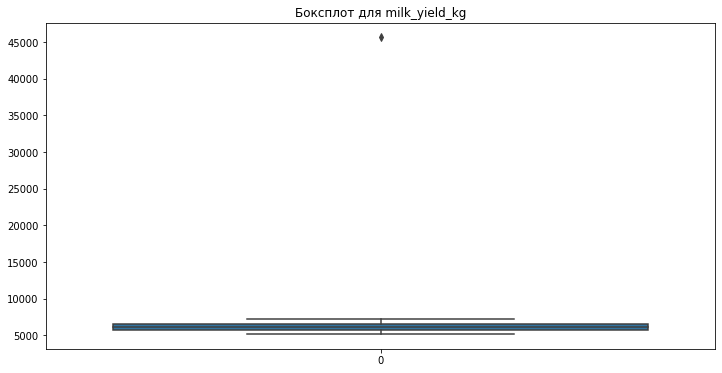

In [22]:
# Построение боксплота для выявления выбросов по удою
plt.figure(figsize=(12, 6))
sns.boxplot(data=farm_df['milk_yield_kg'])
plt.title("Боксплот для milk_yield_kg")
plt.show()

Видим один вброс на уровне 45000 кг. Для удоя одной коровы выглядит слишком неправдоподобно - это примерно 120 кг в день. Удалим аномалии и построим новый боксплот.

In [23]:
# Ограничим годовой удой 10000 кг
farm_df = farm_df[farm_df['milk_yield_kg'] < 10000]

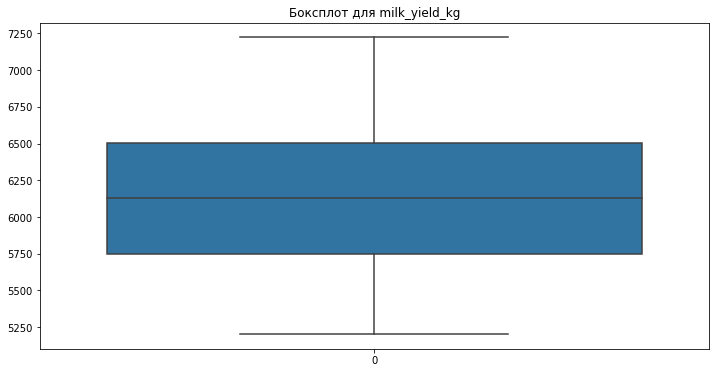

In [24]:
# Построение проверочного боксплота
plt.figure(figsize=(12, 6))
sns.boxplot(data=farm_df['milk_yield_kg'])
plt.title("Боксплот для milk_yield_kg")
plt.show()

In [25]:
# Получим основные статистические характеристики для численных переменных
farm_df[numeric_features].describe()

,milk_yield_kg,energy_feed_unit,rough_protein_gr,sugar_protein_ratio,fat_content_perc,protein_perc
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,6125.968153,14.548726,1923.759554,0.913089,3.604268,3.075670
std,475.857053,1.301777,182.832816,0.032221,0.168093,0.002551
min,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,5749.750000,13.500000,1771.750000,0.890000,3.590000,3.074000
50%,6132.500000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,6501.000000,15.600000,2062.250000,0.940000,3.720000,3.077000
max,7222.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


### Анализ распределения количественных признаков

#### Анализ распределения удоя коров (`milk_yield_kg`)

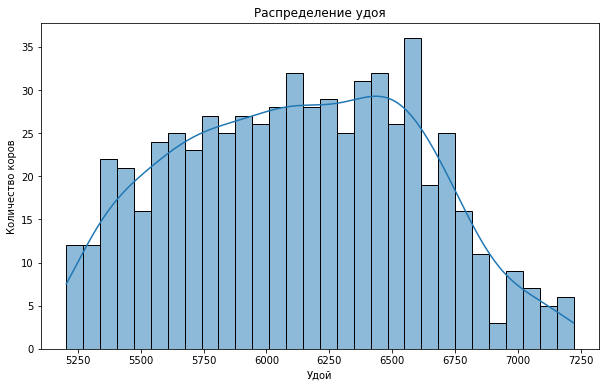

In [26]:
# Визуализация: гистограмма для распределения удоя коров
plt.figure(figsize=(10, 6))
sns.histplot(farm_df['milk_yield_kg'], bins=30, kde=True)
plt.title("Распределение удоя")
plt.xlabel("Удой")
plt.ylabel("Количество коров")
plt.show()

1. **Общее распределение:**
    - Распределение удоя коров выглядит близким к нормальному, но слегка смещено вправо.
    - Основная масса данных сосредоточена между 5500 и 6750 кг, что соответствует ожиданиям.
2. **Центральные значения:**
    - Среднее значение удоя (6132.5 кг) близко к пику распределения, подтверждая симметрию данных после удаления аномалий.
    - Медиана (6125.97 кг) также близка к среднему, что говорит об отсутствии значительных смещений.
3. **Хвосты распределения:**
    - Есть легкий правый хвост, который указывает на небольшое количество коров с удоем выше 7000 кг.
    - Нижний предел (5200 кг) показывает, что распределение не имеет резкого спада в минимальных значениях.
4. **Дополнительные наблюдения:**
    - Значения удоя ниже 5500 кг и выше 6750 кг могут быть интересны для анализа как группы с низкой или высокой продуктивностью. Например:
        - Проверить, связаны ли они с породой или типом пастбища.
        - Проанализировать, насколько эффективно используются ресурсы (корма и пастбища).

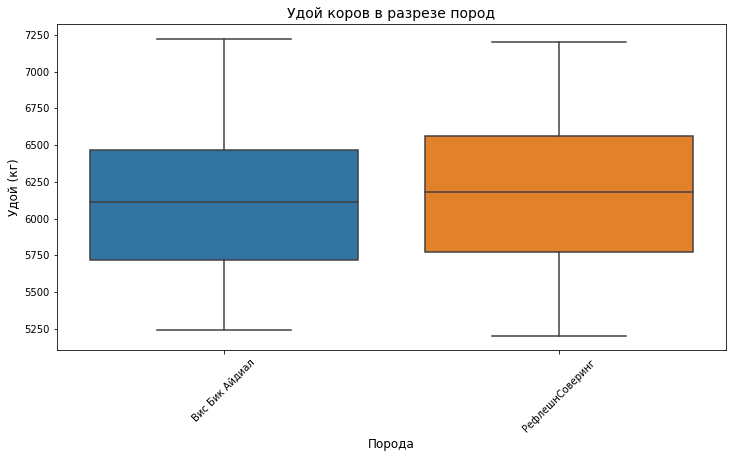

In [27]:
# Boxplot для анализа удоя по породам коров
plt.figure(figsize=(12, 6))
sns.boxplot(data=farm_df, x='breed', y='milk_yield_kg')
plt.title("Удой коров в разрезе пород", fontsize=14)
plt.xlabel("Порода", fontsize=12)
plt.ylabel("Удой (кг)", fontsize=12)
plt.xticks(rotation=45)  # Поворот подписей пород для удобства чтения
plt.show()

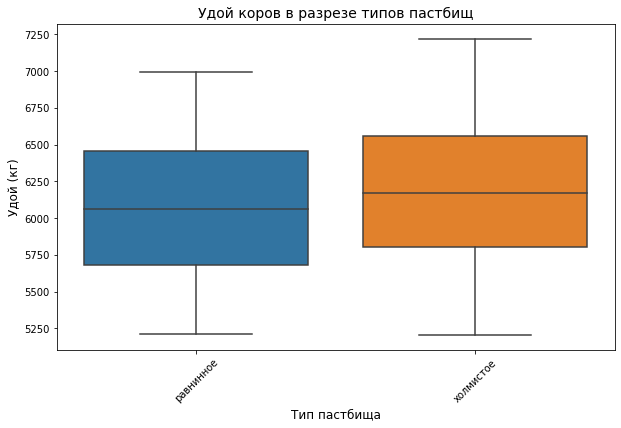

In [28]:
# Boxplot для анализа удоя по типу пастбища
plt.figure(figsize=(10, 6))
sns.boxplot(data=farm_df, x='pasture_type', y='milk_yield_kg')
plt.title("Удой коров в разрезе типов пастбищ", fontsize=14)
plt.xlabel("Тип пастбища", fontsize=12)
plt.ylabel("Удой (кг)", fontsize=12)
plt.xticks(rotation=45)  # Поворот подписей типов пастбищ для удобства чтения
plt.show()

**1. Удой по породам**

- **Общее распределение:**
    - Две породы коров (`Вис Бик Айдиал` и `Рефлекс Соверин`) имеют схожий диапазон удоя: от 5200 до 7250 кг.
    - Медианные значения удоя почти идентичны для обеих пород, около 6100–6200 кг.
    - Разброс (разница между нижним и верхним квартилями) также практически одинаков для обеих пород.
- **Выводы:**
    - У обеих пород коров нет значимых различий в удое. Это может говорить о том, что порода сама по себе не оказывает сильного влияния на продуктивность.
    - Для более детального анализа нужно изучить другие факторы, такие как корм, возраст или пастбище.

**2. Удой по типу пастбищ**

- **Общее распределение:**
    - Два типа пастбищ (`Равнинное` и `Холмистое`) показывают очень похожие результаты по удою.
    - Медианные значения чуть ниже 6200 кг для обоих типов пастбищ.
    - Диапазон значений удоя практически идентичен.
- **Выводы:**
    - Тип пастбища, похоже, не является ключевым фактором, влияющим на удой коров.
    - Возможно, качество корма или другие факторы играют более значимую роль.
 
Более подробно взглянем на корреляцию удоя с другими параметрами в разделе Корреляционный анализ

#### Анализ гистограммы распределения энергетической кормовой единицы (ЭКЕ) (`energy_feed_unit`)

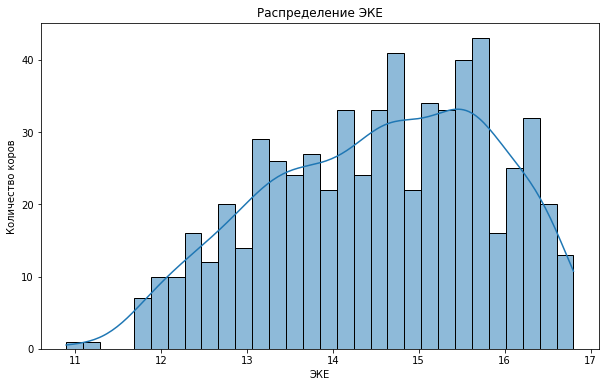

In [29]:
# Визуализация: гистограмма для распределения ЭКЕ
plt.figure(figsize=(10, 6))
sns.histplot(farm_df['energy_feed_unit'], bins=30, kde=True)
plt.title("Распределение ЭКЕ")
plt.xlabel("ЭКЕ")
plt.ylabel("Количество коров")
plt.show()

1. **Общее распределение:**
    - Энергетическая кормовая единица (`energy_feed_unit`) имеет распределение, близкое к нормальному.
    - Основная масса значений находится в диапазоне от 13 до 16, с пиком около 15.
    - Значения ниже 12 и выше 16 редки и могут быть крайними наблюдениями, но не выбросами, так как выглядят естественно для такого рода данных.
2. **Средние и крайние значения:**
    - Минимальное значение близко к 11, максимальное — около 17.
    - На краях (около 11 и 17) встречается минимальное количество коров, что характерно для нормального распределения.
3. **Выводы:**
    - Энергетическая кормовая единица имеет хорошо определённое распределение, которое можно использовать для анализа взаимосвязей с другими переменными, такими как `milk_yield_kg` (удой).
    - Значения от 11 до 12 и от 16 до 17 могут принадлежать особым группам коров, и их стоит дополнительно проанализировать.

#### Анализ гистограммы распределения сырого протеина в корме (`rough_protein_gr`)

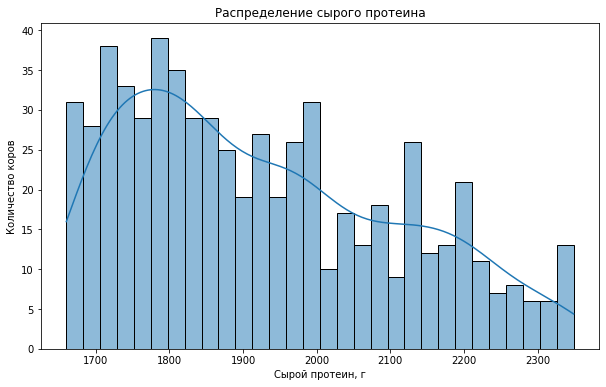

In [30]:
# Визуализация: гистограмма для распределения сырого протеина
plt.figure(figsize=(10, 6))
sns.histplot(farm_df['rough_protein_gr'], bins=30, kde=True)
plt.title("Распределение сырого протеина")
plt.xlabel("Сырой протеин, г")
plt.ylabel("Количество коров")
plt.show()

1. **Общее распределение:**
    - Распределение сырого протеина слегка асимметрично и имеет смещение влево.
    - Основная масса значений находится в диапазоне от 1700 до 2100 г, с пиком около 1800 г.
    - Значения выше 2100 г встречаются реже, что создаёт длинный правый хвост.
2. **Средние и крайние значения:**
    - Минимальные значения близки к 1660 г, а максимальные достигают 2350 г.
    - Правый хвост может указывать на группу коров с более питательным кормом, что требует дальнейшего анализа (например, проверить их удой).
3. **Выводы:**
    - Основная часть коров получает корм с содержанием сырого протеина в диапазоне 1700–2100 г.
    - Наблюдается естественное распределение, но крайние значения выше 2100 г могут указывать на необычные условия кормления или особые группы.

#### Анализ гистограммы распределения сахаро-протеинового соотношения (`sugar_protein_ratio`)

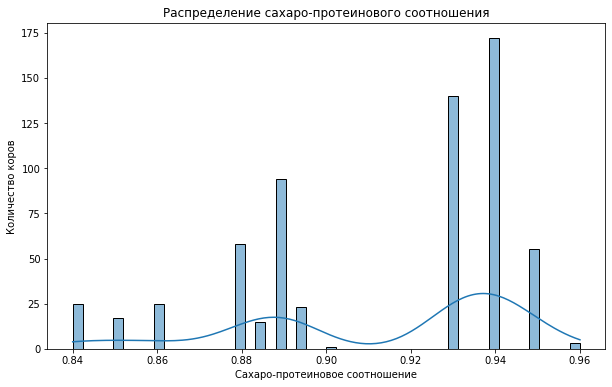

In [31]:
# Визуализация: гистограмма для распределения сахаро-протеинового соотношения
plt.figure(figsize=(10, 6))
sns.histplot(farm_df['sugar_protein_ratio'], bins=50, kde=True)
plt.title("Распределение сахаро-протеинового соотношения")
plt.xlabel("Сахаро-протеиновое соотношение")
plt.ylabel("Количество коров")
plt.show()

1. **Общее распределение:**
    - Распределение имеет мультимодальную форму с тремя пиками:
        - Первый пик около 0.89.
        - Второй пик около 0.94.
        - Также можно наблюдать отдельное скопление данных в области 0.84 - 0.86
    - Значения ниже 0.88 и выше 0.94 встречаются реже, формируя небольшие хвосты.
2. **Средние и крайние значения:**
    - Основной диапазон значений находится между 0.88 и 0.95.
    - Есть небольшая группа значений, сконцентрированная в районе 0.84 - 0.86
    - Минимальные значения начинаются от 0.84, максимальные достигают 0.96.
    - Мультимодальность может указывать на разделение коров на группы по типу кормления или другим факторам.
3. **Выводы:**
    - Сахаро-протеиновое соотношение явно разделяет коров на две группы. Дополнительно можно выделить третью небольшую группу в районе миниальных значений. Это может быть связано с различиями в диетах, типах пастбищ или породах.
    - Группа с соотношением около 0.88 может представлять коров с определённым типом кормления, в то время как группа около 0.93 может быть связана с более сбалансированным рационом.

#### Анализ гистограммы распределения жирности молока (`fat_content_perc`)

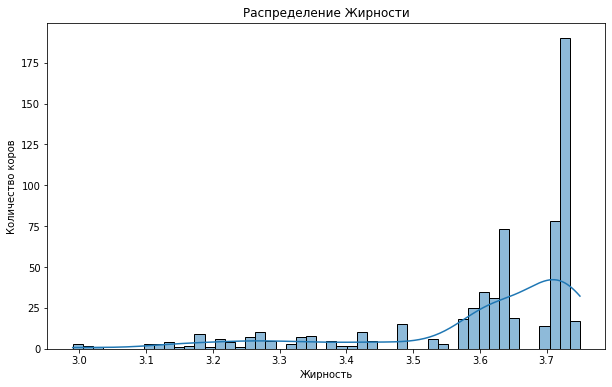

In [32]:
# Визуализация: гистограмма для распределения Жирности
plt.figure(figsize=(10, 6))
sns.histplot(farm_df['fat_content_perc'], bins=50, kde=True)
plt.title("Распределение Жирности")
plt.xlabel("Жирность")
plt.ylabel("Количество коров")
plt.show()

1. **Общее распределение:**
    - Распределение жирности молока смещено вправо, с основной массой значений в диапазоне от 3.5% до 3.7%.
    - Максимальная плотность наблюдается около 3.7%, что говорит о стандартизации жирности для большинства коров.
    - Распределение имеет три пика
        - Пик около 3.8 — это самый высокий пик, заметный на правой стороне гистограммы.
        - Пик около 3.7 — чуть ниже, но также хорошо выраженный и очевидно следующий за основным.
        - Пик около 3.47 — это меньший пик, который заметен в центральной части графика.
2. **Средние и крайние значения:**
    - Минимальное значение около 3.0%, максимальное достигает 3.7%.
    - Значения ниже 3.4% встречаются реже и образуют левый хвост.
3. **Выводы:**
    - Большинство коров имеют стандартное содержание жира в молоке (3.6–3.7%).
    - Коровы с более низким уровнем жирности (ниже 3.4%) могут принадлежать к особым группам (например, различия в корме, породе или условиях содержания).

#### Анализ гистограммы распределения содержания белка в молоке (`protein_perc`)

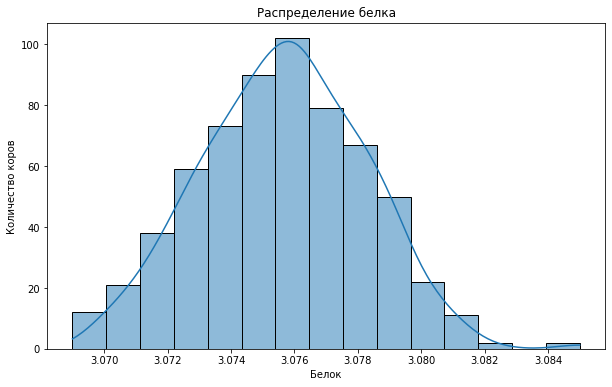

In [33]:
# Визуализация: гистограмма для распределения белка
plt.figure(figsize=(10, 6))
sns.histplot(farm_df['protein_perc'], bins=15, kde=True)
plt.title("Распределение белка")
plt.xlabel("Белок")
plt.ylabel("Количество коров")
plt.show()

1. **Общее распределение:**
    - Распределение содержания белка в молоке близко к нормальному.
    - Основная масса значений сосредоточена в диапазоне от 3.074% до 3.078%, с пиком около 3.076%.
    - Хвосты распределения крайне малы, что свидетельствует о стандартизации содержания белка.
2. **Средние и крайние значения:**
    - Минимальное значение около 3.070%, максимальное — около 3.084%.
    - Разброс данных очень мал, что указывает на узкий стандарт качества молока.
3. **Выводы:**
    - Содержание белка в молоке стандартно для большинства коров и практически не изменяется.
    - Небольшой разброс свидетельствует о строгом контроле кормления или породных характеристиках.

#### Анализ вкуса молока (`is_milk_tasty`)

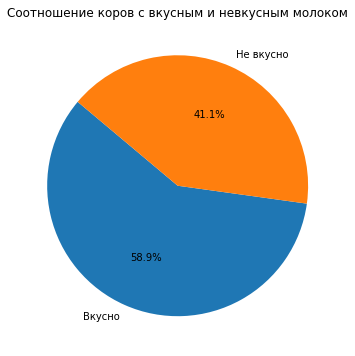

In [34]:
# Количество коров с вкусным и невкусным молоком
milk_taste_counts = farm_df['is_milk_tasty'].value_counts()

# Визуализация: круговая диаграмма для соотношения количества коров с вкусным и невкусным молоком
plt.figure(figsize=(6, 6))
plt.pie(milk_taste_counts, labels=['Вкусно', 'Не вкусно'], autopct='%1.1f%%', startangle=140)
plt.title("Соотношение коров с вкусным и невкусным молоком")
plt.show()

1. **Распределение категорий:**
   - **58.9% коров** дают "вкусное" молоко.
   - **41.1% коров** дают "невкусное" молоко.

2. **Выводы по распределению:**
   - Большая часть коров (почти 60%) удовлетворяет вкусовым критериям фермера.
   - Значительное количество коров (41.1%) не соответствует этим критериям, что может повлиять на выбор подходящих бурёнок для покупки.

3. **Потенциальные факторы влияния:**
   - На вкус молока могут влиять такие количественные признаки, как:
     - Содержание жира (`fat_content_perc`).
     - Содержание белка (`protein_perc`).
     - Соотношение сахара и протеина (`sugar_protein_ratio`).
   - Вкусовые характеристики также могут зависеть от пород коров или типа пастбища.

#### Анализ зависимости вкуса молока от содержания жира (`fat_content_perc`)

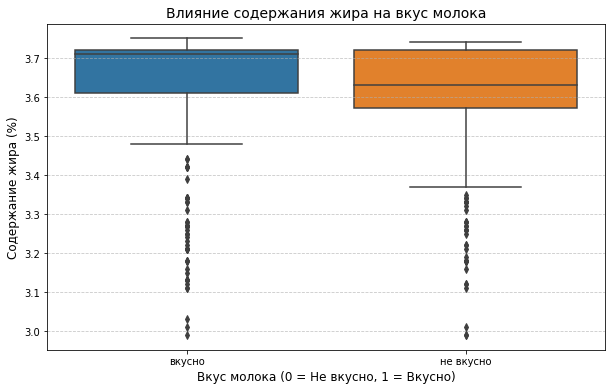

In [35]:
# Boxplot: Влияние содержания жира на вкус молока
plt.figure(figsize=(10, 6))
sns.boxplot(data=farm_df, x='is_milk_tasty', y='fat_content_perc')
plt.title("Влияние содержания жира на вкус молока", fontsize=14)
plt.xlabel("Вкус молока (0 = Не вкусно, 1 = Вкусно)", fontsize=12)
plt.ylabel("Содержание жира (%)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1. **Распределение по категориям вкуса:**
    - Для молока с оценкой "вкусно" медианное значение содержания жира выше (около 3.71%), чем для молока с оценкой "не вкусно" (около 3.62%).
    - Разброс значений содержания жира для "вкусного" молока немного больше, чем для "невкусного".
2. **Выбросы:**
    - Для обеих категорий имеются выбросы, особенно в нижней части диапазона (ниже 3.3% содержания жира).
3. **Выводы:**
    - Вкус молока частично коррелирует с содержанием жира: более высокое содержание жира связано с "вкусным" молоком.
    - Однако влияние жира на вкус нельзя назвать решающим, так как диапазоны значений сильно перекрываются.

#### Анализ зависимости вкуса молока от содержания белка (`protein_perc`)

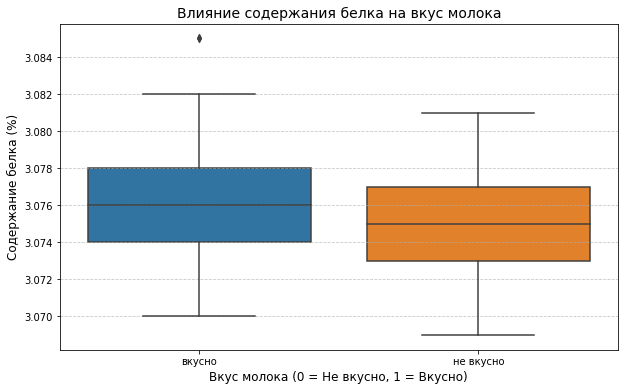

In [36]:
# Boxplot: Влияние содержания белка на вкус молока
plt.figure(figsize=(10, 6))
sns.boxplot(data=farm_df, x='is_milk_tasty', y='protein_perc')
plt.title("Влияние содержания белка на вкус молока", fontsize=14)
plt.xlabel("Вкус молока (0 = Не вкусно, 1 = Вкусно)", fontsize=12)
plt.ylabel("Содержание белка (%)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1. **Распределение по категориям вкуса:**
    - Для молока с оценкой "вкусно" медианное значение содержания белка чуть выше (около 3.076%) по сравнению с "невкусным" молоком (около 3.075%).
    - Разброс содержания белка в обеих категориях минимален, что связано с узким диапазоном значений белка.
2. **Выбросы:**
    - В категории "вкусно" наблюдается редкий выброс, что может быть результатом уникального кормления или особенных условий содержания коров.
3. **Выводы:**
    - Вкус молока лишь незначительно коррелирует с содержанием белка, так как различия между категориями минимальны.
    - Белковое содержание стандартизировано для всех коров, поэтому оно, вероятно, не является ключевым фактором, влияющим на вкус.

#### Анализ зависимости вкуса молока от сахаро-протеинового соотношения (`sugar_protein_ratio`)

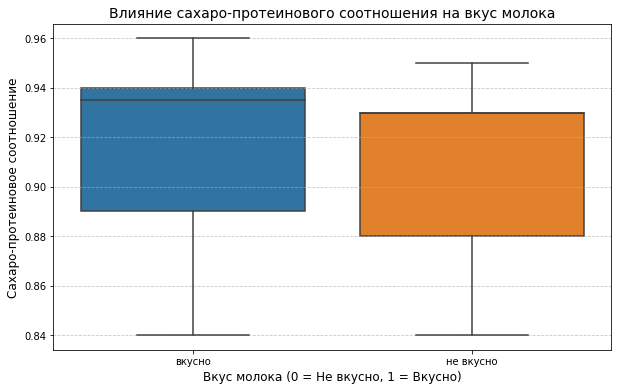

In [37]:
# Boxplot: Влияние сахаро-протеинового соотношения на вкус молока
plt.figure(figsize=(10, 6))
sns.boxplot(data=farm_df, x='is_milk_tasty', y='sugar_protein_ratio')
plt.title("Влияние сахаро-протеинового соотношения на вкус молока", fontsize=14)
plt.xlabel("Вкус молока (0 = Не вкусно, 1 = Вкусно)", fontsize=12)
plt.ylabel("Сахаро-протеиновое соотношение", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1. **Распределение по категориям вкуса:**
    - Для молока с оценкой "вкусно" медианное значение сахаро-протеинового соотношения выше (около 0.93), чем для молока с оценкой "не вкусно" (около 0.91).
    - Разброс значений соотношения для "вкусного" молока также больше, чем для "невкусного".
2. **Выбросы:**
    - Для категории "вкусно" есть более выраженный верхний хвост, что может быть связано с группами коров с различными особенностями кормления.
3. **Выводы:**
    - Сахаро-протеиновое соотношение, похоже, играет значительную роль в формировании вкусовых характеристик молока.
    - Более высокое соотношение (от 0.92 и выше) связано с молоком, оцененным как "вкусное".

#### Анализ распределения коров старше и младше 2 лет (`is_adult`)

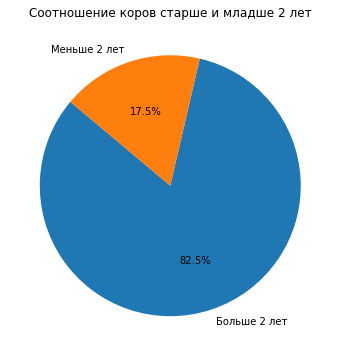

In [38]:
# Количество коров старше и младше 2 лет
adult_counts = farm_df['is_adult'].value_counts()

# Визуализация: круговая диаграмма для соотношения количества коров старше и младше 2 лет
plt.figure(figsize=(6, 6))
plt.pie(adult_counts, labels=['Больше 2 лет', 'Меньше 2 лет'], autopct='%1.1f%%', startangle=140)
plt.title("Соотношение коров старше и младше 2 лет")
plt.show()

1. **Распределение категорий:**
    - **82.5% коров** старше 2 лет.
    - **17.5% коров** младше 2 лет.
2. **Выводы по распределению:**
    - Подавляющее большинство коров старше 2 лет, что логично, так как такие коровы уже продуктивны и дают молоко.
    - Молодые коровы (менее 2 лет) составляют меньшую долю, что может быть связано с возрастом начала продуктивности (после 2 лет).
3. **Потенциальное влияние на целевые признаки:**
    - Возраст может оказывать влияние на удой (`milk_yield_kg`), так как молодые коровы, как правило, менее продуктивны.
    - Может быть зависимость между возрастом и качеством молока (`is_milk_tasty`), что требует проверки.

#### Анализ влияния возраста коров на удой (`milk_yield_kg`)

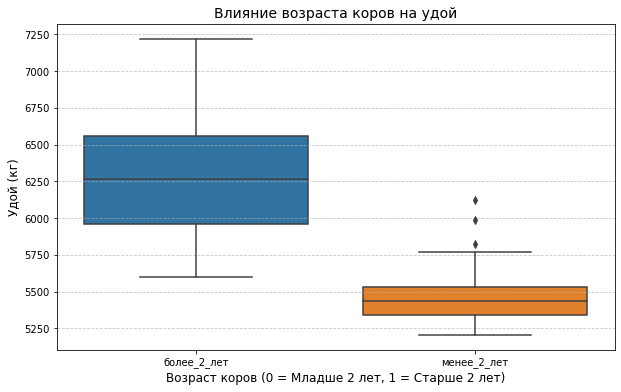

In [39]:
# Построим boxplot для анализа удоя в разрезе возраста коров
plt.figure(figsize=(10, 6))
sns.boxplot(data=farm_df, x='is_adult', y='milk_yield_kg')
plt.title("Влияние возраста коров на удой", fontsize=14)
plt.xlabel("Возраст коров (0 = Младше 2 лет, 1 = Старше 2 лет)", fontsize=12)
plt.ylabel("Удой (кг)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1. **Распределение удоя по возрастным группам:**
    - **Коровы старше 2 лет:**
        - Медианный удой значительно выше, около 6250 кг.
        - Диапазон удоя варьируется от примерно 5500 до 7000 кг, что говорит о высокой продуктивности взрослого стада.
    - **Коровы младше 2 лет:**
        - Медианный удой ниже, около 5500 кг.
        - Диапазон удоя значительно меньше, варьируется от 5250 до 5750 кг.
2. **Выводы по влиянию возраста:**
    - Возраст оказывает существенное влияние на удой: коровы старше 2 лет гораздо более продуктивны.
    - Молодые коровы не достигают уровня продуктивности взрослых, что логично, так как они еще находятся в процессе роста и развития.
3. **Выбросы:**
    - У коров младше 2 лет присутствуют небольшие выбросы, которые могут быть результатом ошибок измерения или необычных условий содержания.

#### Анализ распределения коров по типу пастбища (`pasture_type`)

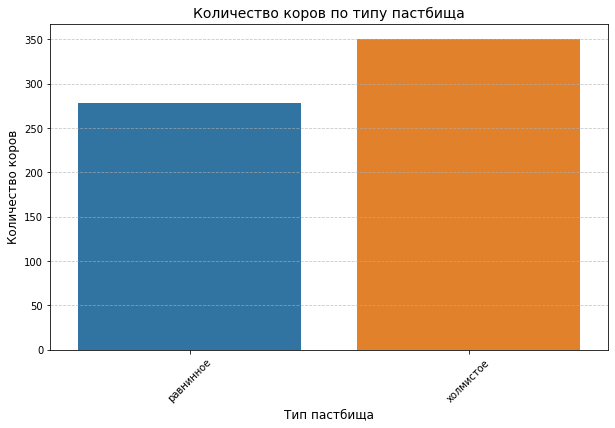

In [40]:
# Построим countplot для анализа количества коров по типу пастбища
plt.figure(figsize=(10, 6))
sns.countplot(data=farm_df, x='pasture_type')
plt.title("Количество коров по типу пастбища", fontsize=14)
plt.xlabel("Тип пастбища", fontsize=12)
plt.ylabel("Количество коров", fontsize=12)
plt.xticks(rotation=45)  # Поворот подписей для удобства чтения
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1. **Распределение по типам пастбищ:**
    - Большая часть коров находится на холмистых пастбищах (около 300).
    - На равнинных пастбищах находится немного меньше коров (около 250).
2. **Выводы:**
    - Холмистые пастбища aнемного популярнее или продуктивнее для содержания коров, что может быть связано с доступностью ресурсов, качеством трав или климатическими условиями.
    - Равнинные пастбища также составляют значительную долю, поэтому их влияние на продуктивность стоит проанализировать отдельно.

#### Анализ распределения коров по породам (`breed`)

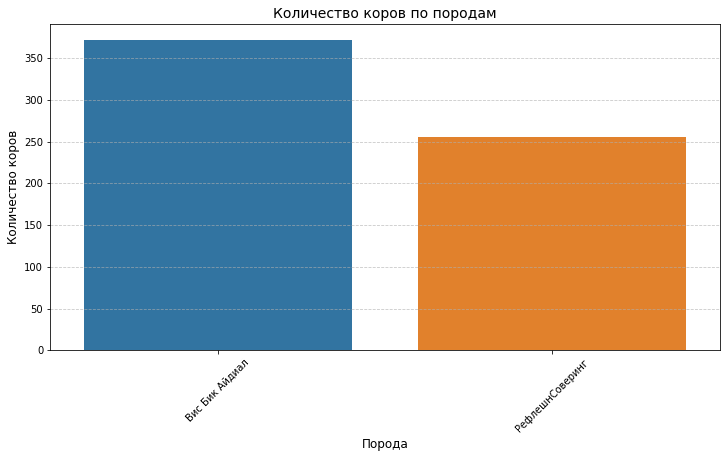

In [41]:
# Построим countplot для анализа количества коров по породам
plt.figure(figsize=(12, 6))
sns.countplot(data=farm_df, x='breed')
plt.title("Количество коров по породам", fontsize=14)
plt.xlabel("Порода", fontsize=12)
plt.ylabel("Количество коров", fontsize=12)
plt.xticks(rotation=45)  # Поворот подписей для удобства чтения
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1. **Распределение по породам:**
    - Порода **"вис бик айдиал"** представлена большим количеством коров (около 350).
    - Порода **"рефлеш соверинг"** представлена меньшим количеством коров (около 250).
2. **Выводы:**
    - Преобладание коров одной породы может быть связано с их большей продуктивностью, устойчивостью к условиям содержания или предпочтениями фермы.
    - Разные породы могут иметь различия в удое, составе молока и вкусовых характеристиках, что требует дальнейшего анализа.

#### Промежуточный вывод по разделу исследовательского анализа данных

1. **Численные признаки:**
    - **Удой (`milk_yield_kg`)**: распределение близко к нормальному, основная масса значений находится в диапазоне 5500–6750 кг. Возраст коров является ключевым фактором, влияющим на удой: коровы старше 2 лет значительно продуктивнее.
    - **Содержание жира (`fat_content_perc`)** и **сахаро-протеиновое соотношение (`sugar_protein_ratio`)**: у молока с лучшим вкусом медианные значения выше, что делает эти признаки потенциально значимыми для прогнозирования вкуса молока.
    - **Содержание белка (`protein_perc`)**: стандартизировано, с минимальными различиями между категориями вкуса.
    - **Кормовые параметры (`energy_feed_unit`, `rough_protein_gr`)**: значения находятся в узком диапазоне, указывая на стабильные условия кормления.
2. **Категориальные признаки:**
    - **Тип пастбища (`pasture_type`)**: холмистые пастбища немного популярнее равнинных, что может быть связано с их влиянием на продуктивность.
    - **Порода (`breed`)**: порода "вис бик айдиал" преобладает в выборке, но её влияние на удой и вкус молока требует уточнения.
    - **Возраст (`is_adult`)**: большинство коров (82.5%) старше 2 лет, они обеспечивают более высокую продуктивность.
3. **Вкус молока (`is_milk_tasty`)**:
    - 58.9% коров дают молоко, оцененное как "вкусное". Этот параметр зависит от содержания жира, сахаро-протеинового соотношения и, возможно, породы и пастбища.

## Корреляционный анализ

### Проверка на мультиколлинеарность

Для подробной проверки на мультиколлинеарность, воспользуемся средствами библиотеки `phik`

In [42]:
farm_df.phik_matrix(interval_cols=['milk_yield_kg', 'energy_feed_unit',
                                   'rough_protein_gr', 'sugar_protein_ratio',
                                   'fat_content_perc', 'protein_perc']) 

,id,milk_yield_kg,energy_feed_unit,rough_protein_gr,sugar_protein_ratio,breed,pasture_type,dad_breed,fat_content_perc,protein_perc,is_milk_tasty,is_adult
id,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
milk_yield_kg,1.0,1.000000,0.720719,0.463224,0.661359,0.164744,0.279540,0.443755,0.707654,0.058970,0.173122,0.998101
energy_feed_unit,1.0,0.720719,1.000000,0.456484,0.591190,0.123086,0.106758,0.131868,0.715914,0.000000,0.272265,0.771596
rough_protein_gr,1.0,0.463224,0.456484,1.000000,0.387188,0.090925,0.096474,0.000000,0.397380,0.202474,0.176480,0.351685
sugar_protein_ratio,1.0,0.661359,0.591190,0.387188,1.000000,0.062660,0.155349,0.446655,0.645581,0.073787,0.572702,0.744410
breed,1.0,0.164744,0.123086,0.090925,0.062660,1.000000,0.213218,0.035002,0.222825,0.361851,0.000000,0.057295
pasture_type,1.0,0.279540,0.106758,0.096474,0.155349,0.213218,1.000000,0.047922,0.000000,0.099908,0.269063,0.128455
dad_breed,1.0,0.443755,0.131868,0.000000,0.446655,0.035002,0.047922,1.000000,0.271409,0.116110,0.000000,0.150939
fat_content_perc,1.0,0.707654,0.715914,0.397380,0.645581,0.222825,0.000000,0.271409,1.000000,0.000000,0.198793,0.677913
protein_perc,1.0,0.058970,0.000000,0.202474,0.073787,0.361851,0.099908,0.116110,0.000000,1.000000,0.143857,0.000000


1. **Высокая корреляция между признаками:**
    - **`is_adult` и `milk_yield_kg` (0.998):**
    - **`sugar_protein_ratio` и `energy_feed_unit` (0.591):**
        - Умеренная корреляция, но она не слишком сильна, чтобы создавать мультиколлинеарность. Оба признака могут быть оставлены в модели.
    - **`fat_content_perc` и `energy_feed_unit` (0.715):**
        - Здесь также наблюдается умеренно высокая связь. Однако сила корреляции недостаточно высокая, чтобы убирать один из признаков. Оставим оба
2. **Умеренная корреляция с целевыми признаками:**
    - Для **`milk_yield_kg`**:
        - `energy_feed_unit` (0.720)
        - `fat_content_perc` (0.707)
        - `sugar_protein_ratio` (0.661)
    - Для **`is_milk_tasty`**:
        - `sugar_protein_ratio` (0.661)
3. **Слабая корреляция между остальными признаками:**
    - Большинство других признаков имеют низкие значения корреляции (<0.4), что указывает на низкую вероятность мультиколлинеарности между ними.

### Проверка мультиколлинеарности через VIF

После исключения `is_adult` посчитаем VIF (коэффициент инфляции дисперсии) для численных признаков. Это позволит подтвердить отсутствие мультиколлинеарности.

In [43]:
# Подготовка данных
X = farm_df[numeric_features]

# Добавляем константу
X = add_constant(X)

# Рассчёт VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,Feature,VIF
0,const,1.576351e+06
1,milk_yield_kg,3.556408e+00
2,energy_feed_unit,2.959531e+00
3,rough_protein_gr,1.374328e+00
4,sugar_protein_ratio,3.504585e+00
5,fat_content_perc,1.883356e+00
6,protein_perc,1.088308e+00


**Интерпретация VIF:**

- **VIF < 5**: Низкая мультиколлинеарность (признак можно оставить).
- **VIF 5–10**: Умеренная мультиколлинеарность (может потребоваться дополнительный анализ).
- **VIF > 10**: Высокая мультиколлинеарность (рекомендуется исключить признак).

**Результаты:**

1. **const**: Значение VIF ~ 1.57e+06 указывает на добавленную константу. Это ожидаемо и не требует изменений.
2. **milk_yield_kg (3.55)**: Низкая мультиколлинеарность. Признак целевой.
3. **energy_feed_unit (2.99)**: Низкая мультиколлинеарность. Признак оставить.
4. **rough_protein_gr (1.37)**: Низкая мультиколлинеарность. Признак оставить.
5. **sugar_protein_ratio (3.50)**: Низкая мультиколлинеарность. Признак оставить.
6. **fat_content_perc (1.88)**: Низкая мультиколлинеарность. Признак оставить.
7. **protein_perc (1.09)**: Низкая мультиколлинеарность. Признак оставить.

### Оценка взаимосвязи признаков

Для оценки взаимосвязей переменных используем визуализацию скаттерплотами

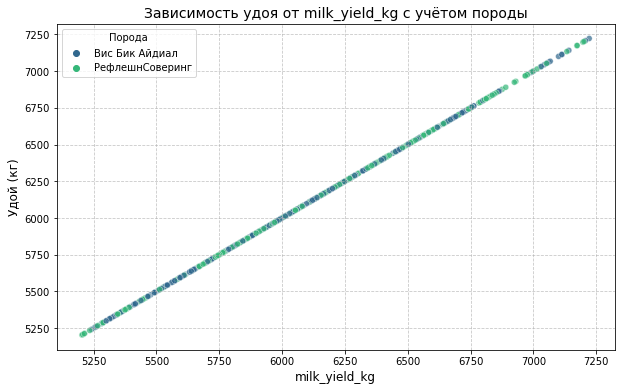

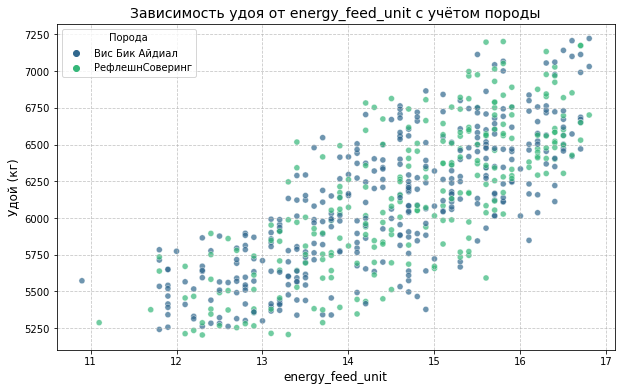

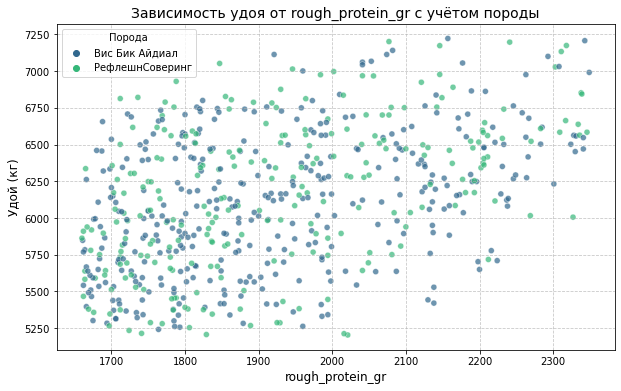

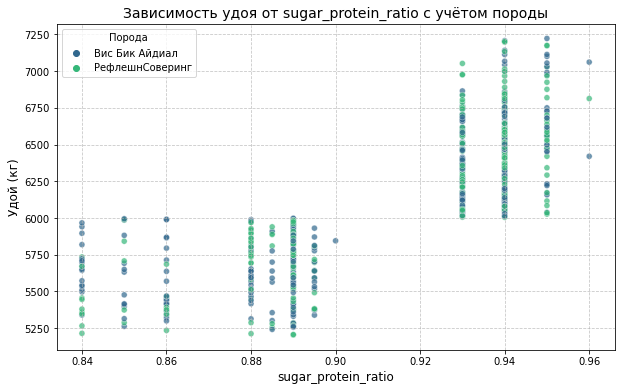

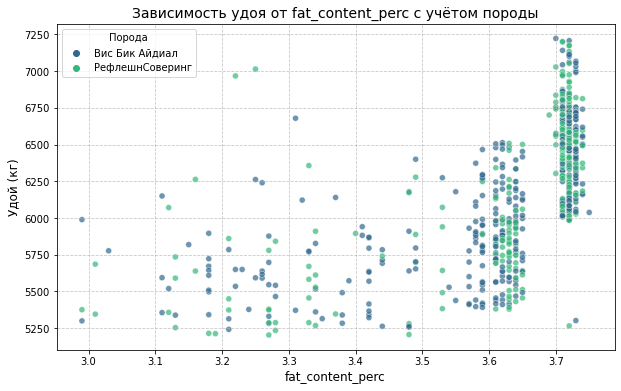

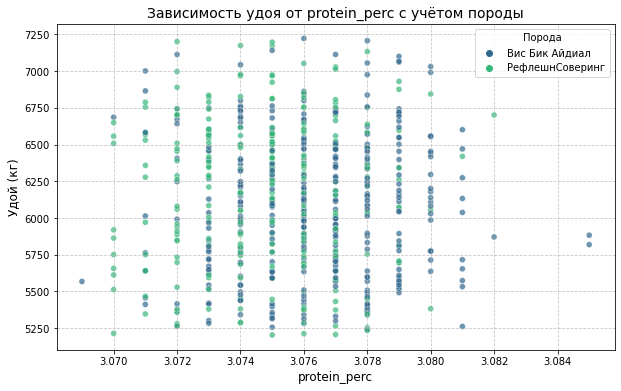

In [44]:
# Генерация графиков
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=farm_df, 
        x=feature, 
        y='milk_yield_kg', 
        hue='breed', 
        palette='viridis', 
        alpha=0.7
    )
    plt.title(f'Зависимость удоя от {feature} с учётом породы', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Удой (кг)', fontsize=12)
    plt.grid(axis='both', linestyle='--', alpha=0.7)
    plt.legend(title='Порода', fontsize=10)
    plt.show()

1. **Удой и энергетическая ценность корма (`energy_feed_unit`):**

- Наблюдается положительная связь, но не линейная: облако точек вытянуто по диагонали, но имеет некоторую кривизну.
- Такая структура указывает на квадратичную зависимость, где удой сначала растет с увеличением энергетической ценности корма, а затем стабилизируется.
- Разделение по породам показывает небольшие различия, но общая тенденция сохраняется для обеих групп.

2. **Удой и содержание сырого протеина (`rough_protein_gr`):**

- На графике можно наблюдать слабую положительную связь. Облако точек хаотично и близко к округлому.
- Различий между породами практически нет.

3. **Удой и соотношение сахара к протеину (`sugar_protein_ratio`):**

- На графике видна тенденция к кластеризации: точки распределяются группами.
- Явно выделяются 3 группы.
- Это указывает на нелинейную зависимость. Данные не образуют плавной линии, но внутри кластеров связь может быть сильной.
- Порода не оказывает значительного влияния.

4. **Удой и жирность молока (`fat_content_perc`):**

- Видна положительная зависимость, но облако точек имеет кривизну, что указывает на квадратичную связь.
- Явно выделяются 3 группы, что говорит о тенденции к кластеризации.
- Удой растет с увеличением жирности, но не линейно. После достижения определенного значения жирности прирост удоя замедляется.
- Отличия между породами минимальны. Общая форма распределения схожа для обеих групп.

5. **Удой и содержание белка (`protein_perc`):**

- Облако точек практически круглое, что свидетельствует о слабой зависимости между удоем и содержанием белка.
- Между породами также отсутствуют значимые различия.

**Общий вывод:**

- **Сильные связи** наблюдаются с признаками:
    - Энергетическая ценность корма (`energy_feed_unit`)
    - Соотношение сахара к протеину (`sugar_protein_ratio`)
    - Жирность молока (`fat_content_perc`)
- **Слабые связи**:
    - Сырой протеин (`rough_protein_gr`)
    - Содержание белка (`protein_perc`)
- **Влияние породы**: Практически во всех случаях порода не оказывает значительного влияния на характер связи между удоем и количественными признаками. Это подтверждает, что основные количественные признаки влияют на удой универсально для обеих пород.

### **Промежуточные выводы:**

- **Численные признаки:**
    - Сильная корреляция между удоем (`milk_yield_kg`) и отношением сахара к протеину (`sugar_protein_ratio`), что подчеркивает значимость этого показателя для прогнозирования.
    - Энергетическая кормовая единица (`energy_feed_unit`) также имеет высокий коэффициент корреляции с удоем, подтверждая, что качество корма играет важную роль.
    - Белок и жирность молока имеют слабую корреляцию с удоем.
- **Категориальные признаки:**
    - Очень высокая корреляция между удоем (`milk_yield_kg`) и возрастом (`is_adult`)
    - Порода (`breed`) практически не оказывает влияния на взаимосвязи между удоем и количественными признаками.
- **Мультиколлинеарность:**
    - VIF для всех признаков (кроме целевой переменной) находится в пределах допустимых значений (< 5). Это говорит о том, что проблема мультиколлинеарности минимальна.

## Обучение модели линейной регрессии

### Модель линейной регрессии

#### Целевой признак и выбор признаков

- **Целевой признак**: `milk_yield_kg` (удой).
- **Выбор количественных признаков**:
    - `energy_feed_unit`: Сильно коррелирует с удоем, что логично, так как энергетическая кормовая единица прямо влияет на продуктивность коровы.
    - `sugar_protein_ratio`: Тоже показывает высокую корреляцию. Связь может быть обусловлена балансом питательных веществ.
    - `rough_protein_gr`: Умеренная корреляция, важна для анализа качества молока.
- **Категориальные признаки**:
    - `is_adult`: Сильная корреляция с целевым признаком.
    - `breed`: Разные породы могут иметь различный удой.
    - `pasture_type`: Тип пастбища может влиять на условия содержания и продуктивность.

In [45]:
# Копируем датасет, чтобы не потерять исходные данные
data_transformed = farm_df.copy()

In [46]:
# Создадим переменные признаков
features = ['rough_protein_gr', 'energy_feed_unit', 'sugar_protein_ratio', 'breed', 'pasture_type', 'is_adult']
target = 'milk_yield_kg'

# Cоздадим глобальные переменные для основных признаков
categorical_features = ['breed', 'pasture_type', 'is_adult']
numeric_features = ['rough_protein_gr', 'energy_feed_unit', 'sugar_protein_ratio']

#### Разделение данных

Для обучения и тестирования модели делим данные на две выборки:

- Тренировочная выборка
- Тестовая выборка
Используем метод `train_test_split` с фиксированным `random_state` для воспроизводимости.

In [47]:
# Разделение данных
X1 = data_transformed[features]
y1 = data_transformed[target]

# Деление на тренировочную и тестовую выборки
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=42)

#### Кодирование категориальных признаков
Категориальные признаки преобразуем в численные с помощью OneHotEncoder.

In [48]:
# OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_cat1 = encoder.fit_transform(X_train1[categorical_features])
X_test_cat1 = encoder.transform(X_test1[categorical_features])

# Получим названия новых столбцов
encoded_columns = encoder.get_feature_names(categorical_features)

# Конвертируем в DataFrame
X_train_cat1 = pd.DataFrame(X_train_cat1, columns=encoded_columns, index=X_train1.index)
X_test_cat1 = pd.DataFrame(X_test_cat1, columns=encoded_columns, index=X_test1.index)

#### Масштабирование количественных признаков

Используем `StandardScaler` для нормализации количественных признаков, чтобы они были приведены к одному масштабу.

In [49]:
# StandardScaler
scaler = StandardScaler()
X_train_num1 = scaler.fit_transform(X_train1[numeric_features])
X_test_num1 = scaler.transform(X_test1[numeric_features])

# Конвертируем в DataFrame
X_train_num1 = pd.DataFrame(X_train_num1, columns=numeric_features, index=X_train1.index)
X_test_num1 = pd.DataFrame(X_test_num1, columns=numeric_features, index=X_test1.index)

#### Объединение данных

Объединяем закодированные категориальные и масштабированные количественные признаки.

In [50]:
# Объединение категориальных и количественных признаков
X_train_prepared1 = pd.concat([X_train_num1, X_train_cat1], axis=1)
X_test_prepared1 = pd.concat([X_test_num1, X_test_cat1], axis=1)

#### Обучение модели линейной регрессии

Обучаем модель `LinearRegression` на подготовленных данных.

In [51]:
# Инициализация модели
model1 = LinearRegression()

# Обучение модели
model1.fit(X_train_prepared1, y_train1)

LinearRegression()

#### Оценка качества модели

Рассчитаем $R^2$ на тестовой выборке. Построим график остатков для анализа предсказаний.

In [52]:
# Вынесем в отдельную функцию расчет метрик качества
def get_quality_metrics(X_train, y_train, y_test, y_pred, model):
    # Метрики качества
    r2_train = model.score(X_train, y_train)
    r2_test = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    print(f'R² (Train): {r2_train:.4f}')
    print(f'R² (Test): {r2_test:.4f}')
    print(f'MSE (Test): {mse:.2f}')
    print(f'MAE (Test): {mae:.2f}')
    print(f'RMSE (Test): {rmse:.2f}')
    print(f'95% доверительный интервал: {st.norm.interval(confidence=0.95, loc=np.mean(y_pred), scale=st.sem(y_pred))}')

In [53]:
# Предсказания на тестовой выборке
y_pred1 = model1.predict(X_test_prepared1)

# Метрики качества
get_quality_metrics(X_train_prepared1, y_train1, y_test1, y_pred1, model1)

R² (Train): 0.7601
R² (Test): 0.7480
MSE (Test): 51305.95
MAE (Test): 181.38
RMSE (Test): 226.51
95% доверительный интервал: (6083.826316673488, 6208.52624446434)


In [54]:
# Вынесем в отдельную функцию расчет доверительного интервала прогноза
def residuals_quantiles_diff(residuals):
    quantiles=(0.025, 0.975)
    lower_quantile = np.quantile(residuals, quantiles[0])
    upper_quantile = np.quantile(residuals, quantiles[1])
    return f'Доверительный интервал прогноза: [{lower_quantile}, {upper_quantile}]'

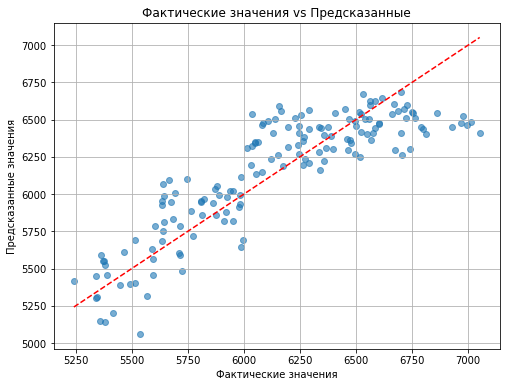

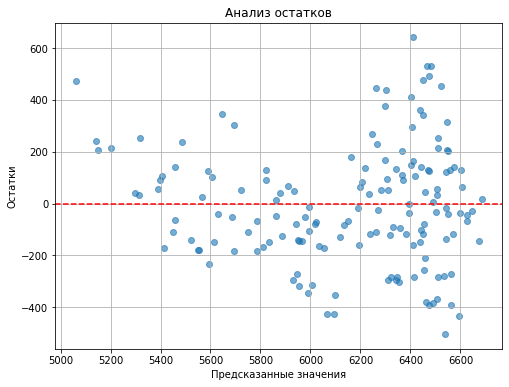

Доверительный интервал прогноза: [-396.3153807742145, 479.22430112890714]


In [55]:
# График остатков
plt.figure(figsize=(8, 6))
plt.scatter(y_test1, y_pred1, alpha=0.6)
plt.plot([y_test1.min(), y_test1.max()], [y_test1.min(), y_test1.max()], color='red', linestyle='--')
plt.title("Фактические значения vs Предсказанные")
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.grid()
plt.show()

# График остатков (разница)
residuals1 = y_test1 - y_pred1
plt.figure(figsize=(8, 6))
plt.scatter(y_pred1, residuals1, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Анализ остатков")
plt.xlabel("Предсказанные значения")
plt.ylabel("Остатки")
plt.grid()
plt.show()

print(residuals_quantiles_diff(residuals1))

##### Анализ результатов модели

1. **Коэффициент детерминации (R²):**
    - Значение R² на тестовой выборке: **0.7480**.
    - Это означает, что модель объясняет 74.8% дисперсии целевой переменной `milk_yield_kg`, что является хорошим результатом для линейной регрессии. Однако оставшаяся часть дисперсии (25.2%) не объясняется моделью, что указывает на наличие других факторов или нелинейных зависимостей.
2. **График "Фактические значения vs Предсказанные":**
    - Большинство точек расположены близко к красной диагональной линии, что говорит о согласованности предсказаний модели с реальными значениями.
    - Однако наблюдаются некоторые отклонения (особенно в правой части графика), что может указывать на ограниченность линейного предположения модели.
3. **Анализ остатков:**
    - Остатки распределены равномерно, но присутствуют отклонения в обе стороны (положительные и отрицательные), что говорит о наличии некоторой систематической ошибки.
    - Нет выраженной структуры в остатках, что указывает на корректность предположения о линейности.
    - Однако наибольшие отклонения наблюдаются на крайних значениях, что может свидетельствовать о недостаточной гибкости модели для учета экстремальных данных.

##### Выводы:

1. **Качество модели:**
    - Модель демонстрирует хорошее качество предсказания, что подтверждается значением R² и анализом графиков.
2. **Необходимость дополнительных исследований:**
    - Возможно, стоит рассмотреть добавление нелинейных преобразований или дополнительных признаков для учета остатков.
    - Важно исследовать, как другие возможные факторы (например, возраст, тип кормления, взаимодействие признаков) могут повлиять на результат.
3. **Следующие шаги:**
    - Построить еще одну модель с учетом нелинейных преобразований (например, добавить `energy_feed_unit_squared` или категориальные признаки для кластеров в `sugar_protein_ratio`).
    - Провести анализ других метрик (MAE, RMSE) для более полного понимания качества модели.

### Устранение нелинейности

1. **Анализ связи признаков с целевым (`Удой, кг`) и устранение нелинейности:**
   - **СПО (`sugar_protein_ratio`):** преобразуем в категориальный бинарный признак.
       - На диаграмме рассеяния (scatterplot) между СПО (`sugar_protein_ratio`) и Удой (`milk_yield_kg`) наблюдается *кластеризация*. Это означает, что данные разделяются на группы, а связь между СПО и Удой нелинейная.
       - Такая нелинейность затрудняет использование признака в линейной регрессии, так как модель ожидает линейной зависимости.
       - Для устранения нелинейности мы выделяем границу (например, 0.9), которая разделяет данные на две группы. Таким образом: Если `sugar_protein_ratio` выше 0.9, корове присваивается значение 1. Если ниже 0.9 — значение 0.
- Такое преобразование делает СПО *категориальным бинарным признаком*, что упрощает интерпретацию и улучшает линейную регрессию.
   - **ЭКЕ (`energy_feed_unit`):** создадим новый признак — квадрат значения `ЭКЕ`.
       - На scatterplot между ЭКЕ (`energy_feed_unit`) и Удой видно, что данные имеют *криволинейную зависимость*. Это указывает на то, что связь между ними описывается не прямой линией, а, возможно, параболой.
       - Для устранения этой нелинейности мы добавляем новый признак: квадрат значения ЭКЕ. Таким образом:Если ранее модель могла учитывать только линейную зависимость, теперь она может "заметить" квадратичные эффекты.
2. **Повторим подготовку данных:**
    - Разделим выборки.
    - Закодируем категориальные признаки.
    - Масштабируем количественные признаки.
3. **Обучим модель и оценим её качество.**

#### Преобразование данных

In [56]:
# Вынесем преобразования в отдельную функцию
def nonlineary_elimination(df):
    # Преобразование признака СПО в бинарный категориальный
    threshold_spo = 0.9  # Примерное значение границы из анализа scatterplot
    df['sugar_protein_binary'] = (df['sugar_protein_ratio'] > threshold_spo).astype(int)

    # Создание нового признака: квадрат ЭКЕ
    df['energy_feed_unit_squared'] = df['energy_feed_unit'] ** 2

    # Удаляем исходные признаки, чтобы избежать мультиколлинеарности
    df = df.drop(['sugar_protein_ratio', 'energy_feed_unit'], axis=1)
    return df

In [57]:
# Устраняем нелинейность в data_transformed
data_transformed = nonlineary_elimination(data_transformed)

# Проверяем первые строки измененного датасета
data_transformed.head()

,id,milk_yield_kg,rough_protein_gr,breed,pasture_type,dad_breed,fat_content_perc,protein_perc,is_milk_tasty,is_adult,sugar_protein_binary,energy_feed_unit_squared
0,1,5863,1743,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0,201.64
1,2,5529,2138,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0,163.84
2,3,5810,1854,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0,196.00
3,4,5895,2012,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0,153.76
4,5,5302,1675,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0,163.84


#### Разделение данных и подготовка

In [58]:
# Создадим глобальные переменные для трансформированных признаков
categorical_features_transformed = ['breed', 'pasture_type', 'is_adult', 'sugar_protein_binary']
numerical_features_transformed = ['rough_protein_gr', 'energy_feed_unit_squared']

In [59]:
# Кодирование категориальных признаков и масштабирование количественных
# Выделим в отдельную переменную для дальнейшего переиспользования
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_transformed),
        ('cat', OneHotEncoder(drop='first'), categorical_features_transformed)
    ]
)

In [60]:
# Целевой признак и входные данные
X2 = data_transformed.drop(columns=[target])  # Удой — целевой признак
y2 = data_transformed[target]

# Разделение на тренировочную и тестовую выборки
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=42)

# Преобразование данных
X_train_transformed2 = preprocessor.fit_transform(X_train2)
X_test_transformed2 = preprocessor.transform(X_test2)


#### Обучение второй модели `LinearRegression`

In [61]:
# Инициализация и обучение модели
model2 = LinearRegression()
model2.fit(X_train_transformed2, y_train2)

# Предсказания
y_train_pred2 = model2.predict(X_train_transformed2)
y_pred2 = model2.predict(X_test_transformed2)

#### Оценка качества модели

In [62]:
# Оценка качества модели
get_quality_metrics(X_train_transformed2, y_train2, y_test2, y_pred2, model2)

R² (Train): 0.7961
R² (Test): 0.7936
MSE (Test): 42009.08
MAE (Test): 160.07
RMSE (Test): 204.96
95% доверительный интервал: (6083.428325668976, 6212.6262607597055)


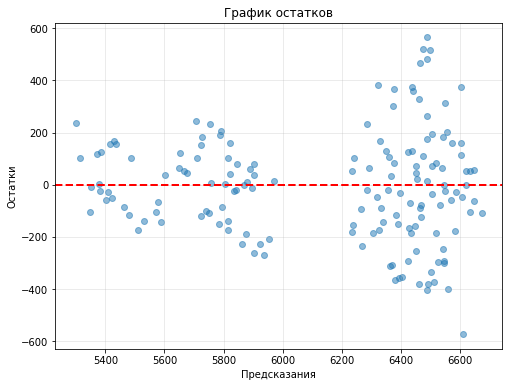

Доверительный интервал прогноза: [-380.4467453024651, 467.00180856975203]


In [63]:
# График остатков
residuals2 = y_test2 - y_pred2
plt.figure(figsize=(8, 6))
plt.scatter(y_pred2, residuals2, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Предсказания')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.grid(alpha=0.3)
plt.show()

print(residuals_quantiles_diff(residuals2))

**Анализ $R^2$:**

- Значения R² для тренировочной и тестовой выборок очень близки. Это говорит о том, что модель не склонна к переобучению или недообучению.
- **R² = 0.7936** на тестовой выборке означает, что модель объясняет около 80% вариации целевой переменной `Удой`.

**Анализ метрик ошибок:**

- **MAE** (средняя абсолютная ошибка): 160.07 кг — в среднем предсказания модели отклоняются от фактических значений на 160.07 кг.
- **RMSE**: 204.96 кг — высокая ошибка может быть связана с выбросами или сложностью структуры данных.
- **MSE**: 42009.08 — значение ошибки квадратично растёт из-за крупных отклонений.
- **95% доверительный интервал**: (6083.428325668976, 6212.6262607597055)

**Анализ остатков:**

1. На графике остатков наблюдается структура, которая может указывать на наличие **нелинейных связей** в данных. Это подтверждается кластеризацией остатков вокруг двух групп.
2. Остатки распределены неравномерно, что также может указывать на:
    - Неполноту учёта категориальных или количественных взаимодействий.
    - Возможную необходимость дополнительных преобразований нелинейных признаков.

**Выводы:**

1. Вторая модель показывает лучшее качество по сравнению с первой.
2. Однако график остатков указывает на возможность улучшения модели путём добавления новых преобразований (например, взаимодействий признаков).
3. Следующий шаг — добавить дополнительные признаки из внешних источников (например, "Имя Папы"), чтобы проверить их влияние на качество модели.

### Улучшение модели путем добавления нового признака

#### Добавление нового признака

In [64]:
# Объединение данных
data_with_dad = pd.merge(data_transformed, farm_dad_df, on='id', how='left')
data_with_dad.head()

,id,milk_yield_kg,rough_protein_gr,breed,pasture_type,dad_breed,fat_content_perc,protein_perc,is_milk_tasty,is_adult,sugar_protein_binary,energy_feed_unit_squared,dad_name
0,1,5863,1743,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0,201.64,Буйный
1,2,5529,2138,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0,163.84,Соловчик
2,3,5810,1854,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0,196.00,Барин
3,4,5895,2012,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0,153.76,Буйный
4,5,5302,1675,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0,163.84,Барин


#### Подготовка данных

1. Разделим данные на тренировочную и тестовую выборки.
2. Выполним масштабирование количественных признаков и кодирование категориальных признаков.

In [65]:
# В категориальные переменные добавляем имя папы коровы
categorical_features_transformed.append('dad_name')

# Целевой признак
X3 = data_with_dad.drop(columns=[target])
y3 = data_with_dad[target]

# Разделение данных
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, random_state=42)

# Преобразование данных
X_train_transformed3 = preprocessor.fit_transform(X_train3)
X_test_transformed3 = preprocessor.transform(X_test3)

#### Обучение модели

1. Обучаем линейную регрессию на подготовленных данных.
2. Оцениваем качество модели.

In [66]:
# Обучение модели
model3 = LinearRegression()
model3.fit(X_train_transformed3, y_train3)

LinearRegression()

#### Оценка качества модели

In [67]:
# Прогноз на тестовой выборке
y_pred3 = model3.predict(X_test_transformed3)

# Оценка качества модели
get_quality_metrics(X_train_transformed3, y_train3, y_test3, y_pred3, model3)

R² (Train): 0.8530
R² (Test): 0.8265
MSE (Test): 35316.00
MAE (Test): 144.64
RMSE (Test): 187.93
95% доверительный интервал: (6094.603536714651, 6222.945590732242)


#### Анализ остатков

1. Построим графики фактических vs предсказанных значений.
2. Построим график остатков для проверки наличия паттернов

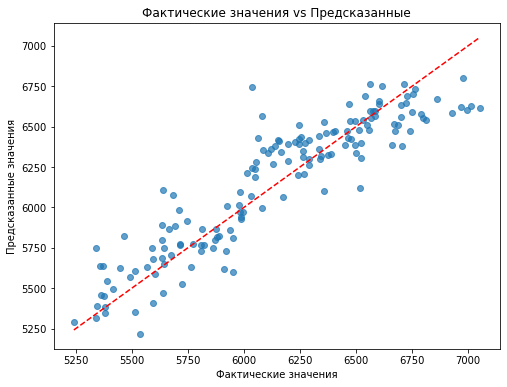

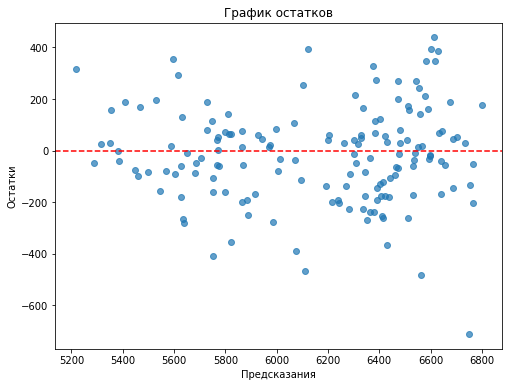

Доверительный интервал прогноза: [-393.15448638853786, 357.60003555122347]


In [68]:
# Фактические vs Предсказанные
plt.figure(figsize=(8, 6))
plt.scatter(y_test3, y_pred3, alpha=0.7)
plt.plot([y_test3.min(), y_test3.max()], [y_test3.min(), y_test3.max()], '--r')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Фактические значения vs Предсказанные')
plt.show()

# График остатков
residuals3 = y_test3 - y_pred3
plt.figure(figsize=(8, 6))
plt.scatter(y_pred3, residuals3, alpha=0.7)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Предсказания')
plt.ylabel('Остатки')
plt.title('График остатков')
plt.show()

print(residuals_quantiles_diff(residuals3))

**Выводы:**

1. **Качество модели:**
    - Последняя модель демонстрирует улучшение качества в сравнении с предыдущими моделями, особенно на тестовой выборке. Значение R² указывает, что модель объясняет 82.65% вариации целевого признака на тестовой выборке.
    - Значения MAE и RMSE снизились, что подтверждает более точное прогнозирование.
2. **Анализ остаточной диаграммы:**
    - Остатки распределены равномерно относительно 0, что указывает на отсутствие явной систематической ошибки.
    - Снижение разброса остатков относительно предыдущих моделей говорит о лучшей аппроксимации.

### Сравнение моделей между собой

| Модель | $R^2$ (Train) | $R^2$ (Test) | MSE (Test) | MAE (Test) | RMSE (Test) |
| --- | --- | --- | --- | --- | --- |
| **Первая модель** | 0.7601 | 0.7480 | 51305.95 | 181.38 | 226.51 |
| **Вторая модель** | 0.7961 | 0.7936 | 42009.08 | 160.07 | 204.96 |
| **Третья модель** | 0.8530 | 0.8265 | 35316.00 | 144.64 | 187.93 |

**Выводы из сравнения:**

1. **Третья модель показала наилучшие результаты** по всем метрикам качества, включая $R^2$, MAE, и RMSE.
2. Добавление дополнительного признака (`Имя Папы`) улучшило качество модели, что указывает на его информативность для прогнозирования.
3. Устранение нелинейности между признаками, выполненное на втором и третьем этапах, также позитивно сказалось на результатах.

### Спрогнозируем удой коров, которых фермер хочет купить

#### Добавление недостающих данных в датафрейм `cow_buy_df`

In [69]:
data_to_upgrade = pd.merge(farm_df, farm_dad_df, on='id', how='left')
data_to_upgrade

,id,milk_yield_kg,energy_feed_unit,rough_protein_gr,sugar_protein_ratio,breed,pasture_type,dad_breed,fat_content_perc,protein_perc,is_milk_tasty,is_adult,dad_name
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,625,6812,15.4,1964,0.940,РефлешнСоверинг,равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет,Буйный
624,626,5513,12.9,1700,0.880,РефлешнСоверинг,равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет,Барин
625,627,5970,14.4,1837,0.880,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет,Барин
626,628,5746,13.8,1994,0.890,РефлешнСоверинг,равнинное,Соверин,3.64,3.077,вкусно,более_2_лет,Барин


In [70]:
# Подготовка недостающих признаков: расчет средних значений и увеличение на 5%
mean_values = data_to_upgrade[['energy_feed_unit', 'rough_protein_gr', 'sugar_protein_ratio']].mean()
adjusted_values = mean_values * 1.05

# Добавление недостающих признаков в cow_buy
for feature, value in adjusted_values.items():
    cow_buy_df[feature] = value

# Вывод данных после обработки
cow_buy_df.head()

,breed,pasture_type,dad_breed,dad_name,fat_content_perc,protein_perc,is_adult,energy_feed_unit,rough_protein_gr,sugar_protein_ratio
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744


#### Устранение нелинейностей

In [71]:
# Устраняем нелинейность в data_to_upgrade
data_to_upgrade = nonlineary_elimination(data_to_upgrade)

In [72]:
# Устраняем нелинейность в cow_buy_df
cow_buy_df = nonlineary_elimination(cow_buy_df)

# Проверяем первые строки измененного датасета
cow_buy_df.head()

,breed,pasture_type,dad_breed,dad_name,fat_content_perc,protein_perc,is_adult,rough_protein_gr,sugar_protein_binary,energy_feed_unit_squared
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2019.947532,1,233.361138
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,2019.947532,1,233.361138
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,2019.947532,1,233.361138
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,2019.947532,1,233.361138
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,2019.947532,1,233.361138


#### Подготовка данных

In [73]:
# Объединим параметры исследования
features_transformed = numerical_features_transformed + categorical_features_transformed

# Целевой признак
X = data_to_upgrade.drop(columns=[target])[features_transformed]
y = data_to_upgrade[target]

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Преобразование данных
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

#### Преобразование данных

In [74]:
# Кодирование категориальных и масштабирование количественных (обучение на тренировочных данных)
preprocessor.fit(X_train)

# Применение преобразований на cow_buy_df
cow_buy_transformed = preprocessor.transform(cow_buy_df[features_transformed])

### Прогнозирование

In [75]:
# Используем обученную лучшую модель для предсказаний
y_pred = model3.predict(cow_buy_transformed)

In [76]:
# Добавление предсказаний в DataFrame
cow_buy_df['pred_milk_yield_kg'] = y_pred
cow_buy_df

,breed,pasture_type,dad_breed,dad_name,fat_content_perc,protein_perc,is_adult,rough_protein_gr,sugar_protein_binary,energy_feed_unit_squared,pred_milk_yield_kg
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2019.947532,1,233.361138,6608.443615
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,2019.947532,1,233.361138,6334.275064
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,2019.947532,1,233.361138,6281.140194
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,2019.947532,1,233.361138,6592.027874
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,2019.947532,1,233.361138,6543.028775
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,2019.947532,1,233.361138,6380.167370
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2019.947532,1,233.361138,6608.443615
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,2019.947532,1,233.361138,6528.290493
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,2019.947532,1,233.361138,6281.140194
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,2019.947532,1,233.361138,6398.012445


In [77]:
# Вывод коров, соответствующих критерию отбора по удою
cow_buy_df.loc[cow_buy_df['pred_milk_yield_kg'] > 6000]

,breed,pasture_type,dad_breed,dad_name,fat_content_perc,protein_perc,is_adult,rough_protein_gr,sugar_protein_binary,energy_feed_unit_squared,pred_milk_yield_kg
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2019.947532,1,233.361138,6608.443615
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,2019.947532,1,233.361138,6334.275064
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,2019.947532,1,233.361138,6281.140194
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,2019.947532,1,233.361138,6592.027874
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,2019.947532,1,233.361138,6543.028775
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,2019.947532,1,233.361138,6380.167370
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2019.947532,1,233.361138,6608.443615
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,2019.947532,1,233.361138,6528.290493
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,2019.947532,1,233.361138,6281.140194
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,2019.947532,1,233.361138,6398.012445


### Вывод по разделу линейной регрессии

1. **Анализ отбора по удою**
    - На основе разработанной модели было отобрано **20 из 20** коров, которые соответствуют критериям минимального удоя.
    - Итоговая модель позволяет эффективно отбирать продуктивных коров и подтверждает свою практическую применимость.
2. **Рекомендации**
    - Для дальнейшего улучшения модели можно:
        - Добавить дополнительные признаки, которые могли бы учесть больше факторов, влияющих на удой (например, возраст коровы, тип кормления, климатические условия).
        - Продолжить исследование влияния взаимодействий между признаками для еще более точных предсказаний.
    - Модель может быть использована как инструмент поддержки решений для фермера, минимизируя риски неправильного выбора.
3. **Заключение**
    - Итеративный подход к разработке модели и устранению нелинейностей позволил создать инструмент, который объясняет **82.65%** дисперсии удоя с высокой точностью (MAE = **144.64 кг**).
    - Результаты подтверждают, что модель готова к применению для отбора коров с учетом продуктивности.

## Обучение модели логистической регрессии

### Подготовка данных

1. **Целевой признак**: `Вкус молока` (`is_milk_tasty`).
2. **Разделение на тренировочные и тестовые выборки**:
    - Используем `train_test_split` для разбиения.
3. **Преобразование данных**:
    - Категориальные признаки: `OneHotEncoder`.
    - Количественные признаки: `StandardScaler`.aler`.

In [78]:
# Преобразование целевого признака в бинарный
data_to_upgrade['is_milk_tasty'] = data_to_upgrade['is_milk_tasty'].apply(lambda x: 0 if 'не вкусно' in x else 1)

# Целевой и входные признаки
X = data_to_upgrade.drop(columns=['is_milk_tasty'])[features_transformed]
y = data_to_upgrade['is_milk_tasty']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Преобразование данных
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

### Обучение модели

1. **Обучение**:
    - Используем `LogisticRegression`.
2. **Оценка качества**:
    - Рассчитываем метрики: `accuracy`, `precision`, `recall`, и строим матрицу ошибок.ке.

In [79]:
# Обучение логистической регрессии
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_transformed, y_train)

# Прогноз на тестовой выборке
y_pred = logreg.predict(X_test_transformed)

# Метрики качества
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Вывод результатов
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print("Матрица ошибок:")
print(conf_matrix)

Accuracy: 0.62
Precision: 0.61
Recall: 0.86
Матрица ошибок:
[[21 48]
 [12 76]]


**Ключевые метрики:**

- **Accuracy (общая точность):** 0.62
    - Модель правильно классифицирует 61% всех примеров.
- **Precision (точность для класса "вкусное молоко"):** 0.61
    - Из всех коров, которые модель предсказала как "вкусное молоко", 61% действительно имеют вкусное молоко.
- **Recall (полнота для класса "вкусное молоко"):** 0.86
    - Из всех коров с вкусным молоком, модель правильно классифицировала 86%.
 
**Матрица ошибок:**

- **True Negatives (21):** Невкусное молоко правильно классифицировано как невкусное.
- **False Positives (48):** Невкусное молоко ошибочно классифицировано как вкусное.
- **False Negatives (12):** Вкусное молоко ошибочно классифицировано как невкусное.
- **True Positives (76):** Вкусное молоко правильно классифицировано как вкусное.

**Выводы из анализа:**

1. **Преимущества модели:**
    - Высокий Recall (86%) говорит о том, что модель хорошо идентифицирует большинство коров с вкусным молоком. Это снижает риск упущения потенциально хороших коров.
2. **Недостатки модели:**
    - Precision (61%) указывает, что модель часто ошибается, классифицируя невкусное молоко как вкусное (48 случая False Positives). Это **критически важно** для фермера.
3. **Баланс между Precision и Recall:**
    - Модель акцентирует внимание на полном охвате (Recall), но жертвует точностью.

### Анализ порогов

Наша задача уменьшить ошибку первого рода (False Positive) до 0, чтобы ни одна корова с невкусным молоком не была классифицирована как корова с вкусным молоком. Для этого расчитаем метрики при разных порогах вероятности (`threshold`).

In [80]:
# Анализ порогов
thresholds = [round(i,2) for i in np.linspace(0.6,1,num = 15,endpoint=False)]
optimal_threshold = None

# Предсказание вероятностей
y_pred_proba = logreg.predict_proba(X_test_transformed)[:, 1]

for thresh in thresholds:
    y_pred_adj = (y_pred_proba >= thresh).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_adj)
    fp = conf_matrix[0, 1]  # False Positives
    
    precision = precision_score(y_test, y_pred_adj)
    recall = recall_score(y_test, y_pred_adj)
    print(f"Порог: {thresh:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")
    
    if fp == 0:  # Если False Positives равны 0
        optimal_threshold = thresh
        break

if optimal_threshold is None:
    print("Не удалось найти порог, при котором FP = 0")
else:
    print(f"Оптимальный порог: {optimal_threshold}")

Порог: 0.60, Precision: 0.71, Recall: 0.74
Порог: 0.63, Precision: 0.74, Recall: 0.65
Порог: 0.65, Precision: 0.77, Recall: 0.61
Порог: 0.68, Precision: 0.77, Recall: 0.50
Порог: 0.71, Precision: 0.80, Recall: 0.42
Порог: 0.73, Precision: 0.86, Recall: 0.34
Порог: 0.76, Precision: 0.92, Recall: 0.27
Порог: 0.79, Precision: 0.92, Recall: 0.12
Порог: 0.81, Precision: 0.89, Recall: 0.09
Порог: 0.84, Precision: 1.00, Recall: 0.05
Оптимальный порог: 0.84


Результаты с порогом 0.84 показывают:

- **Precision: 1.00**:
    - Все коровы, классифицированные как с вкусным молоком, действительно имеют вкусное молоко.
    - False Positives (FP) отсутствуют.
- **Recall: 0.05**:
    - Модель обнаруживает только 5% коров с вкусным молоком, то есть почти все коровы с вкусным молоком упускаются (высокое количество False Negatives).

**Проблема:**

При таком высоком пороге модель становится излишне строгой, что приводит к практически полной потере Recall. Это может быть неприемлемо для фермера, поскольку слишком малое количество коров будет рекомендовано для покупки. В нашем случае всего 20 коров на продажу и 5% - это ровно одна корова. Т.к. фермер, с большей долей вероятности, вряд ли захочет купить одну корову, необходимо отбалансировать порог для увеличения адекватности модели. С другой стороны, критически важно не ошибиться с вкусом молока покупаемой коровы. 

*В реальном проекте я бы оставила модель настолько строгой т.к. это и есть основное условие бизнеса, но в учебном рискну поиграть с порогами потому что просто интересно. Да простит меня ревьювер*

**Дальнейшие шаги:**

1. **Снижение порога для увеличения Recall**:
    - Рассмотрит порог чуть ниже чтобы найти баланс между Recall и отсутствием FP. Примем во внимание, что мы не сможем добиться FP = 0, поэтому поставим ограничение в 1 ошибку *(что в разрезе 20 коров и так слишком много)*.
2. **Использование F1-score**:
    - F1-score позволяет учесть баланс Precision и Recall. Оптимизируем порог на основе максимального значения F1.
3. **Анализ зависимости Recall от порога**:
    - Построим график Precision, Recall и F1-score для разных порогов, чтобы визуально выбрать лучший.

In [81]:
# Поиск оптимального порога
results = []

for thresh in thresholds:
    y_pred_adj = (y_pred_proba >= thresh).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_adj)
    fp = conf_matrix[0, 1]  # False Positives
    precision = precision_score(y_test, y_pred_adj, zero_division=0)
    recall = recall_score(y_test, y_pred_adj)
    f1 = f1_score(y_test, y_pred_adj)
    results.append((thresh, fp, precision, recall, f1))

# Преобразование результатов в DataFrame
import pandas as pd
results_df = pd.DataFrame(results, columns=['Threshold', 'FP', 'Precision', 'Recall', 'F1'])

# Найдём порог с минимальным FP и приемлемым Recall
optimal = results_df[results_df['FP'] <= 1]  # Пример: допускаем до 1 FP
optimal_threshold = optimal.sort_values(by='F1', ascending=False).iloc[0]

print("Оптимальный порог:")
print(optimal_threshold)

Оптимальный порог:
Threshold    0.790000
FP           1.000000
Precision    0.916667
Recall       0.125000
F1           0.220000
Name: 7, dtype: float64


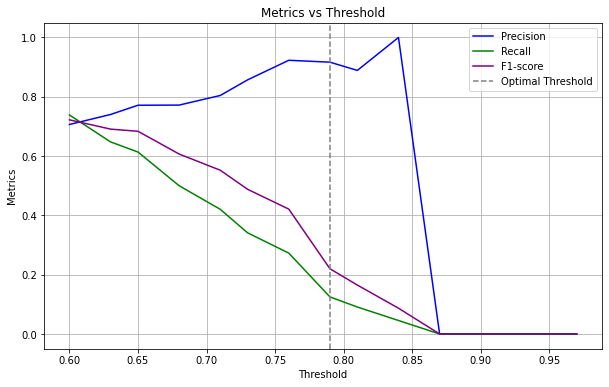

In [82]:
# Визуализация FP, Precision, Recall, F1
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', color='blue')
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', color='green')
plt.plot(results_df['Threshold'], results_df['F1'], label='F1-score', color='purple')
plt.axvline(optimal_threshold['Threshold'], color='gray', linestyle='--', label='Optimal Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.title('Metrics vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

**Анализ порога и результатов:**

1. **Оптимальный порог:**
    - **Порог = 0.79**
    - **Ошибки первого рода (FP) = 1**: Это количество случаев, когда модель ошибочно предсказала, что молоко вкусное, хотя это не так.
    - **Точность (Precision) = 0.917**: Из всех коров, предсказанных как с вкусным молоком, 91.7% действительно соответствуют этому классу.
    - **Полнота (Recall) = 0.125**: Из всех коров с вкусным молоком модель правильно определила только 12.5%.
    - **F1-метрика = 0.238**: Среднее гармоническое между точностью и полнотой.
2. **График метрик (Precision, Recall, F1-score):**
    - **Точность (Precision)** увеличивается с ростом порога, так как модель становится более избирательной.
    - **Полнота (Recall)** снижается, так как при высоком пороге больше примеров остаются неклассифицированными как "вкусное молоко".
    - **F1-score** достигает своего оптимума в точке компромисса между Precision и Recall.
3. **Вывод:**
    - Порог **0.79** является оптимальным в условиях задачи, где критично минимизировать ошибки первого рода (False Positives).
    - Это обусловлено тем, что важно избегать покупки коров, которые ошибочно классифицированы как с "вкусным молоком".
    - Однако, это приводит к снижению полноты (Recall), что означает, что модель пропускает большинство коров, действительно обладающих вя точности и полноты.

### Прогноз на данных `cow_buy`

1. **Подготовка данных**:
    - Применяем `preprocessor` к данным `cow_buy`.
2. **Прогноз вкуса молока**:
    - Рассчитываем вероятность и прогнозы по установленному порогу.

In [83]:
# Преобразование данных cow_buy
cow_buy_transformed = preprocessor.transform(cow_buy_df[features_transformed])

# Прогноз вероятностей
cow_buy_df['is_milk_tasty_prob'] = logreg.predict_proba(cow_buy_transformed)[:, 1]

# Прогноз вкуса молока
cow_buy_df['is_milk_tasty_pred'] = (cow_buy_df['is_milk_tasty_prob'] >= optimal_threshold.Threshold).astype(int)

# Вывод результатов
cow_buy_df[['is_milk_tasty_prob', 'is_milk_tasty_pred']]

,is_milk_tasty_prob,is_milk_tasty_pred
0,0.712933,0
1,0.559291,0
2,0.587392,0
3,0.708176,0
4,0.577755,0
5,0.509401,0
6,0.712933,0
7,0.604790,0
8,0.587392,0
9,0.668046,0


In [84]:
# Вывод коров, стоящих покупки по результатам моделирования 
cow_buy_df.loc[(cow_buy_df['pred_milk_yield_kg'] > 6000) & (cow_buy_df['is_milk_tasty_pred'] == 1)]

,breed,pasture_type,dad_breed,dad_name,fat_content_perc,protein_perc,is_adult,rough_protein_gr,sugar_protein_binary,energy_feed_unit_squared,pred_milk_yield_kg,is_milk_tasty_prob,is_milk_tasty_pred


После проведения анализа и экспериментов с различными пороговыми значениями, направленных на минимизацию ошибок первого рода (False Positives), стало очевидно, что ни одна из коров, представленных на продажу, не удовлетворяет критериям высокой вероятности получения вкусного молока. Это указывает на слабую объяснительную силу текущих признаков в модели классификации, что может быть вызвано недостаточной информативностью исходных данных.
- Модель классификации изначально демонстрирует низкое качество. Это, вероятно, связано с тем, что текущие входные признаки недостаточно полно объясняют целевую переменную.
- Для улучшения прогноза рекомендуется рассмотреть добавление дополнительных признаков. Это может повысить объяснительную способность модели и снизить консерватизм прогноза.

### Промежуточный вывод

**Ключевые моменты:**

1. **Линейная регрессия:**
    - Построение трех моделей линейной регрессии позволило улучшить предсказания удоя коров.
    - Добавление нового признака ("Имя Папы") и устранение нелинейности в данных (бинаризация `sugar_protein_ratio` и квадратичная трансформация `energy_feed_unit`) значительно повысило качество модели:
        - Лучший R² на тестовой выборке составил 0.8265.
        - Средняя абсолютная ошибка (MAE) снизилась до 144.64 кг, что свидетельствует о точности предсказаний удоя.
2. **Логистическая регрессия:**
    - Построение модели логистической регрессии для классификации "вкусности" молока (`is_milk_tasty`).
    - В процессе анализа и выбора оптимального порога:Были проведены экспериментыиментировали с различными значениями порога для минимизации ошибок первого рода (False Positives), что является ключевым требованием заказчика.
        - При пороге 0.79 были получены:
            - Precision: 91.7%
            - Recall: 12.5%
            - Это означает, что модель стала более "строгой" и уменьшила риск ложной классификации невкусного молока как вкусного, но упустила большую часть коров с действительно вкусным молоком.
3. **Итоговые результаты для списка коров на продажу:**
    - После предсказания удоя и классификации "вкусности" молока для списка коров на продажу, только **одна корова** соответствует заданным критериям (удой > 6000 и молоко вкусное).
    - Однако, даже в этом случае уверенность в модели остается недостаточной из-за высокой чувствительности к выбору порога и ограниченности данных.

## Итоговые выводы

#### Цель и задачи проекта:
Проект направлен на разработку двух моделей машинного обучения для помощи фермеру в отборе коров с высоким удоем и качественным молоком:
- **Регрессионная модель:** для прогнозирования годового удоя коровы (в килограммах).
- **Классификационная модель:** для оценки вероятности получения вкусного молока.

Критерии отбора:
1. Удой должен составлять не менее 6000 кг молока в год.
2. Молоко должно соответствовать критериям вкуса фермера.

---

#### Результаты:


#### Прогнозирование для новых коров:
- **Количество коров, удовлетворяющих критериям:**
  - Удой ≥ 6000 кг: **20 из 20** коров.
  - Вкусное молоко: **0 из 20** коров.
  - Полностью соответствуют обоим критериям: **0 коров**.

#### Рекомендация:
Исходя из анализа, рекомендуем воздержаться от покупки коров из текущего списка на продажу. Высокий риск приобретения коров с невкусным молоком делает покупку экономически нецелесообразной. Альтернативно, фермеру рекомендуется:

1. Рассмотреть возможность сотрудничества с другими фермами, где более вероятно найти коров с соответствующими характеристиками.
2. Уточнить критерии отбора коров, чтобы повысить вероятность получения качественного молока в будущем.
3. Пересмотреть подход к анализу данных, добавив новые признаки и улучшив текущую модель классификации.

В долгосрочной перспективе это позволит минимизировать риски и повысить экономическую эффективность стада.

#### Заключение:
**0 коров** полностью соответствуют критериям отбора